In [34]:
import numpy as np
import gymnasium as gym 
from gymnasium import spaces
import IPython
import matplotlib.pyplot as plt

In [35]:
class FarmEnv(gym.Env):
    def __init__(self, grid_size, wheat_spawns, obstacles):
        super(FarmEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(5)  # 0: up, 1: down, 2: left, 3: right, 4: harvest
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size[0], grid_size[1], 3), dtype=np.float32)
        self.wheat_spawns = wheat_spawns
        self.obstacles = obstacles
        self.harvester_path = []  # Track the path of the harvester
        self.reset()

    def reset(self):
        self.grid = np.zeros(self.grid_size)
        self.position_harvester = [0, 0]  # Example initial position
        for pos in self.wheat_spawns:
            self.grid[pos[0], pos[1]] = 1  # Wheat
        for pos in self.obstacles:
            self.grid[pos[0], pos[1]] = -1  # Obstacle
        self.harvester_path.append(list(self.position_harvester))
        return self._get_observation(), self._get_reward(), self._check_done(), {}
    
    def step(self, action):
        # Update the position of the harvester based on the action
        if action == 0 and self.position_harvester[0] > 0:  # Up
            self.position_harvester[0] -= 1 # X - 1
        elif action == 1 and self.position_harvester[0] < self.grid_size[0] - 1:  # Down
            self.position_harvester[0] += 1 # X + 1
        elif action == 2 and self.position_harvester[1] > 0:  # Left
            self.position_harvester[1] -= 1 # Y - 1
        elif action == 3 and self.position_harvester[1] < self.grid_size[1] - 1:  # Right
            self.position_harvester[1] += 1 # Y + 1

        # Handle harvest action and other conditions
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == 1:
            # Harvest wheat
            self.grid[self.position_harvester[0], self.position_harvester[1]] = 0
            # Increase reward or update state as needed for harvesting

        observation = self._get_observation()
        reward = self._get_reward()
        done = self._check_done()
        info = {}  # Additional info for debugging
        return observation, reward, done, info

    def render(self, mode='human'):
        # Create a figure and axis
        fig, ax = plt.subplots()
        ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, self.grid_size[0] - 0.5)
        plt.gca().invert_yaxis()
        
        # Plot wheat, obstacles, truck, and harvester
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if [i, j] == self.position_harvester:
                    ax.plot(j, i, 'bs', color='blue', label='Harvester')  # Harvester as blue square
                elif self.grid[i, j] == 1:
                    ax.plot(j, i, 'yo', label='Wheat')  # Wheat as yellow circle
                elif self.grid[i, j] == -1:
                    ax.plot(j, i, 'ko', label='Obstacle')  # Obstacle as black circle
        
        # Plot the path of the harvester
        for pos in self.harvester_path:
            ax.plot(pos[1], pos[0], 'b.')  # Path as blue dots

        # Set the limits, labels, and title
        ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, self.grid_size[0] - 0.5)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('Farm Environment')

        # Show the plot
        plt.gca().invert_yaxis()  # Invert y-axis to match the grid representation
        plt.show()
        
    def _get_observation(self):
        # Create a state representation
        state = np.zeros(self.grid_size)

        # Mark the position of the harvester
        state[self.position_harvester[0], self.position_harvester[1]] = 2  # Representing the harvester

        # Overlay the wheat and obstacles onto the state
        state += self.grid

        return state
    
    def _get_reward(self):
        # Example reward structure
        reward = 0

        # Positive reward for harvesting wheat
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == 1:
            reward += 10
            self.grid[self.position_harvester[0], self.position_harvester[1]] = 0  # Remove the wheat

        # Negative reward for hitting an obstacle
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == -1:
            reward -= 5

        # Other reward conditions can be added

        return reward

    def _check_done(self):
        # Check if all wheat has been harvested
        if np.sum(self.grid == 1) == 0:
            return True

        # Other conditions, such as fuel depletion, can be added

        return False


In [36]:
class Combine:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = {}

    def choose_action(self, state):
        # Convert state to a tuple to use it as a key in the Q-table
        state = tuple(state.flatten())

        # Exploration-exploitation trade-off
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 5)  # Explore: choose a random action
        else:
            # Exploit: choose the best action based on the current Q-table
            self.q_table.setdefault(state, np.zeros(5))
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        # Convert states to tuples
        state = tuple(state.flatten())
        next_state = tuple(next_state.flatten())

        # Predicted Q-value for current state-action pair
        current_q = self.q_table.setdefault(state, np.zeros(5))[action]

        # Maximum Q-value for actions in the next state
        max_future_q = np.max(self.q_table.setdefault(next_state, np.zeros(5)))

        # Calculate the new Q-value
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.gamma * max_future_q)

        # Update the Q-table
        self.q_table[state][action] = new_q

    def update_epsilon(self, min_epsilon=0.01, decay_rate=0.995):
        # Reduce epsilon (exploration rate) to gradually shift from exploration to exploitation
        if self.epsilon > min_epsilon:
            self.epsilon *= decay_rate


In [ ]:
def animation_plot(env, ax):
    # Update plot for each frame
    ax.clear()
    grid = np.array(env.grid)  # Convert the grid to a NumPy array for visualization

    # Display the field
    ax.imshow(grid, cmap='YlGn_r', interpolation='none', alpha=0.8)

    # Plot the position of the harvester
    ax.scatter(env.position_harvester[1], env.position_harvester[0], color='blue', label='Harvester', s=100)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

def update(frame):
    # Perform a step in the environment and update the plot
    action = harvester.choose_action(env._get_observation())
    env.step(action)
    animation_plot(env, ax)


C:\Users\Marco\AppData\Local\Temp\ipykernel_3584\610397380.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bs" (-> color='b'). The keyword argument will take precedence.
  ax.plot(j, i, 'bs', color='blue', label='Harvester')  # Harvester as blue square


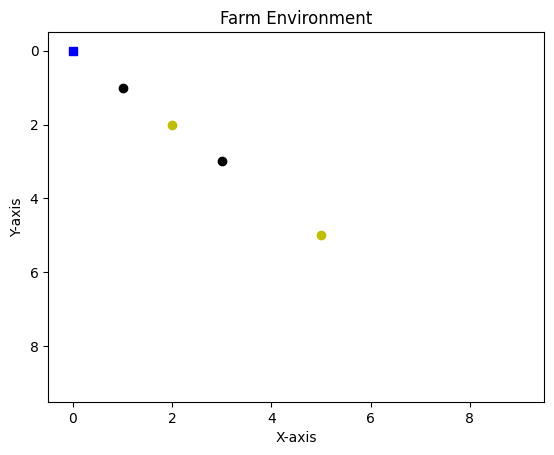

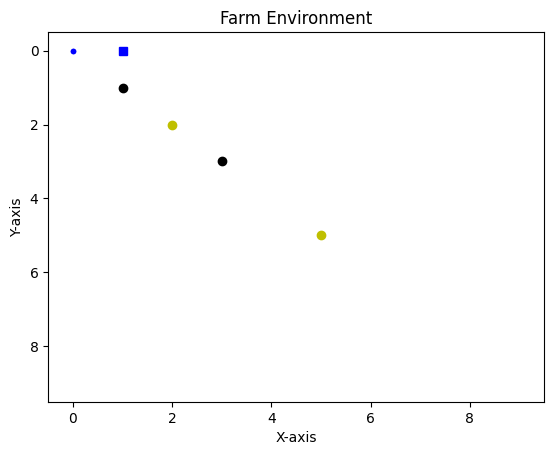

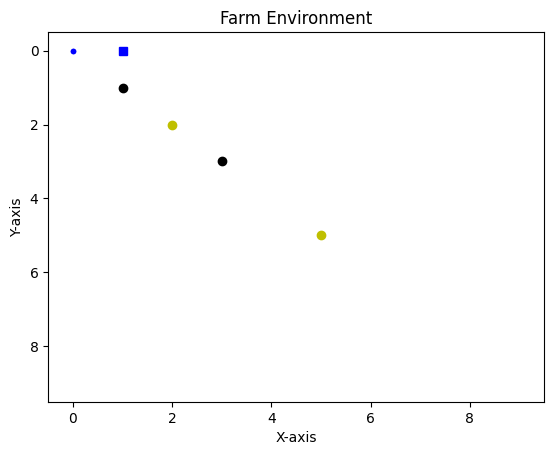

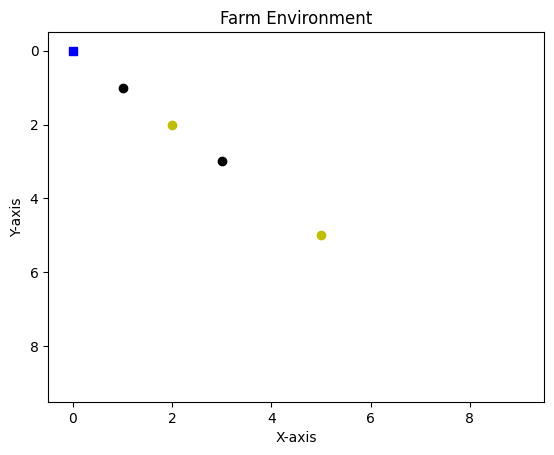

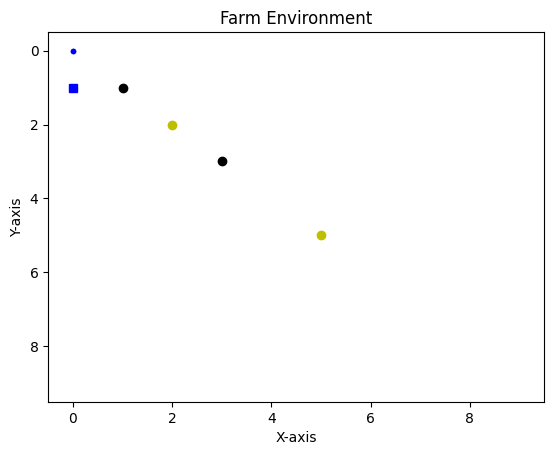

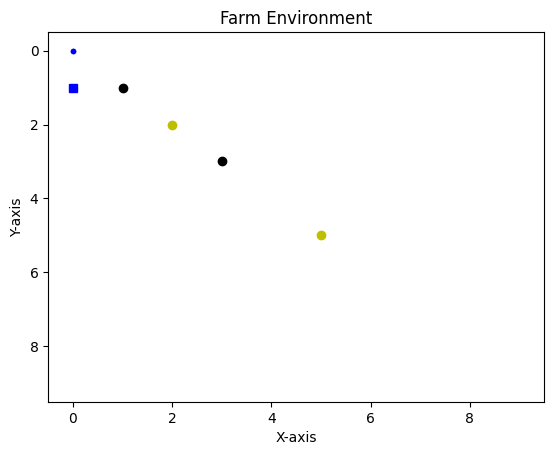

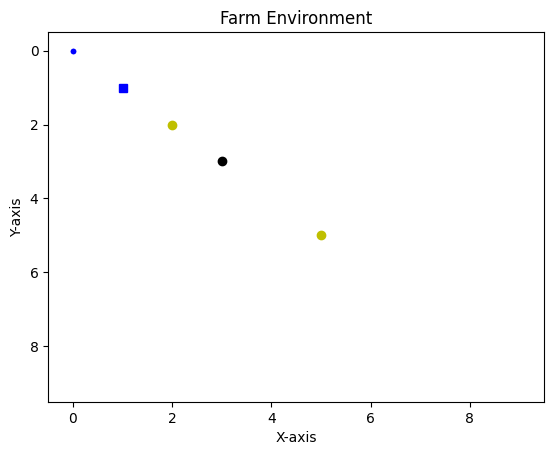

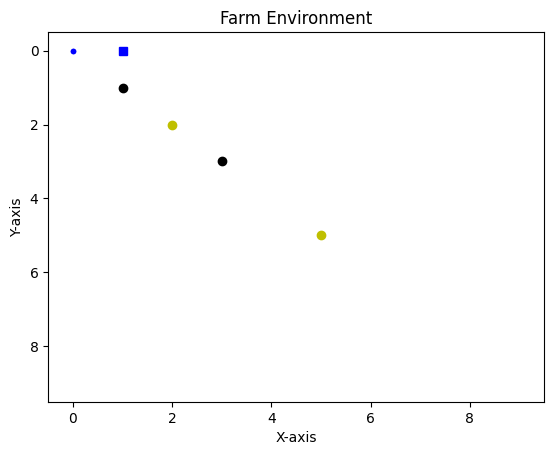

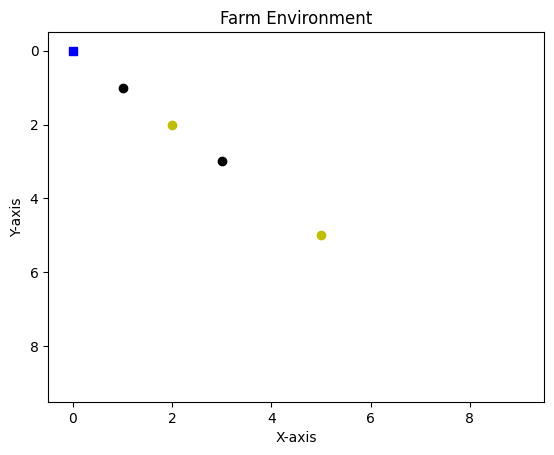

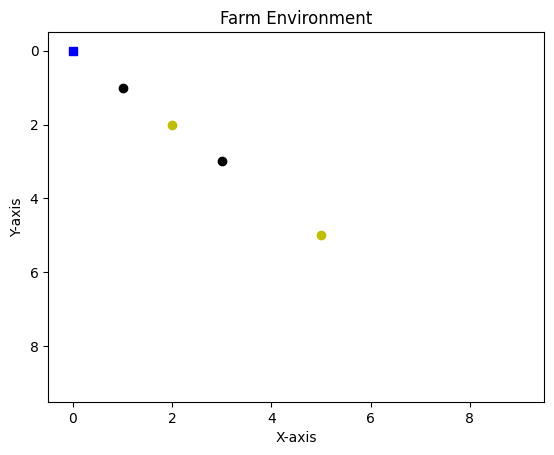

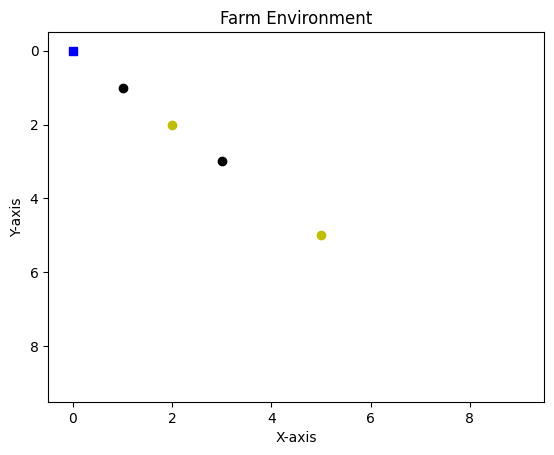

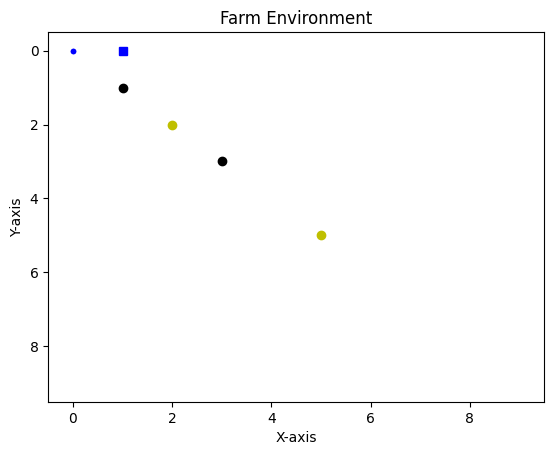

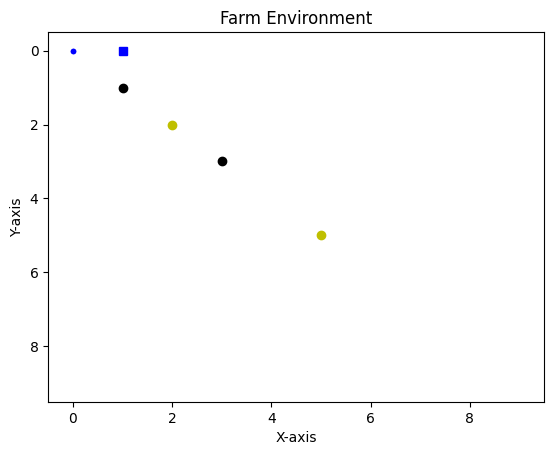

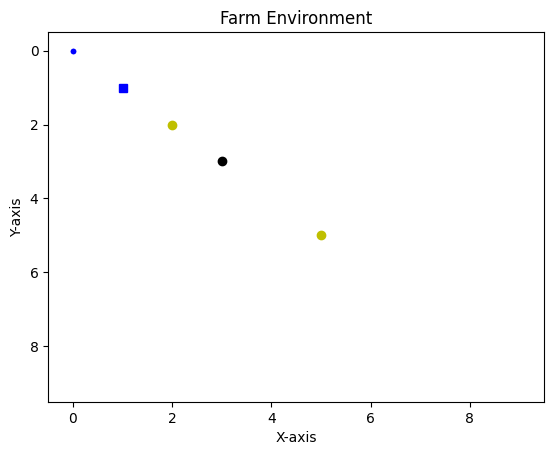

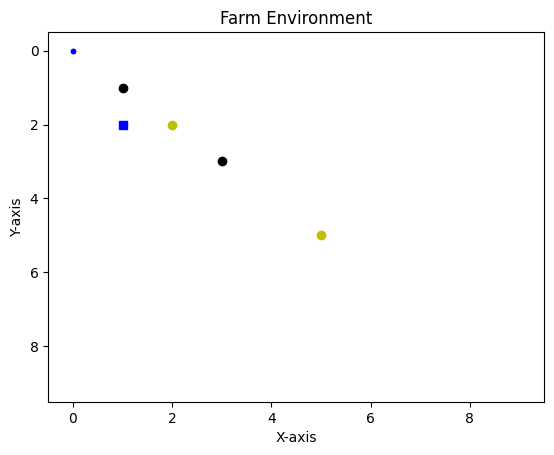

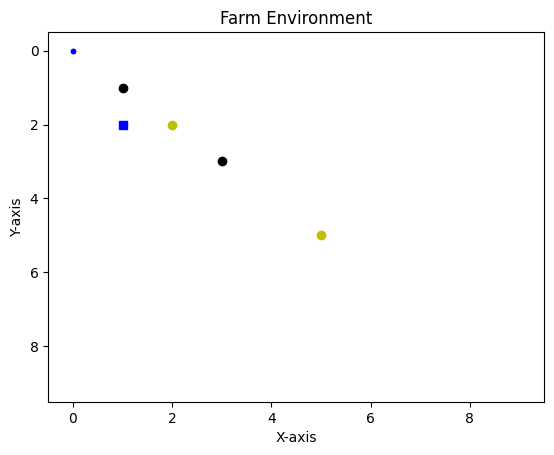

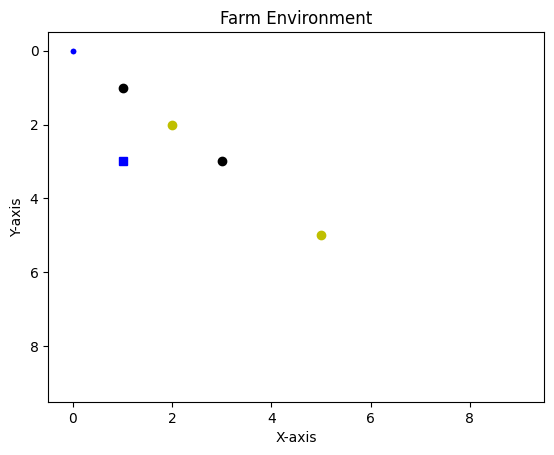

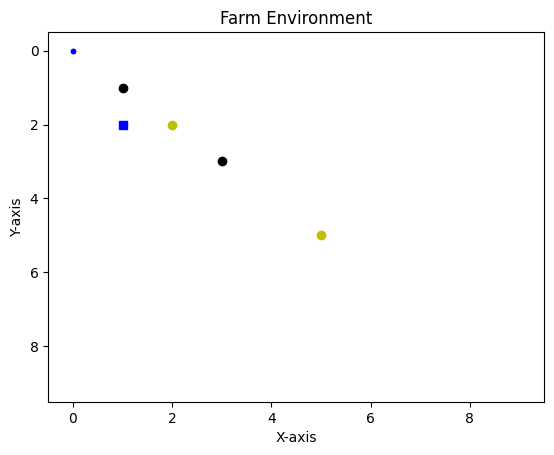

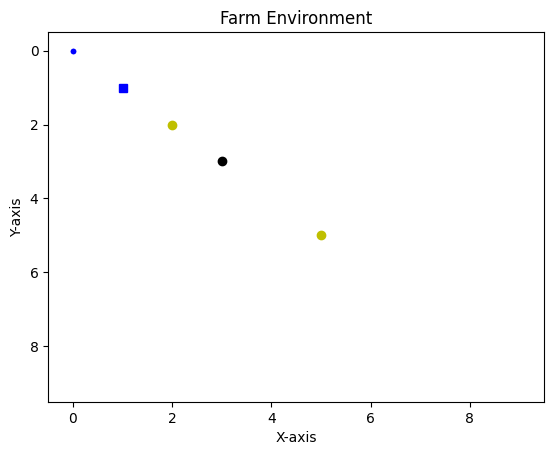

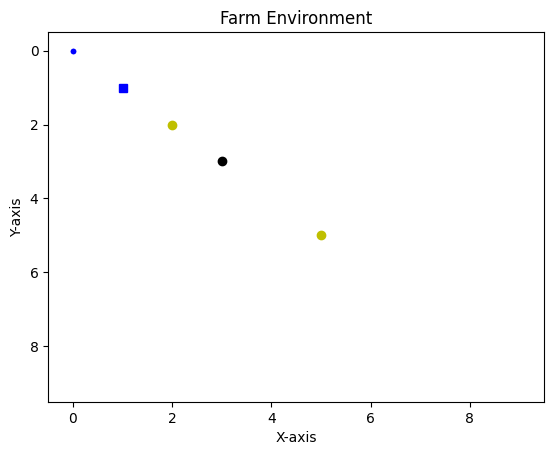

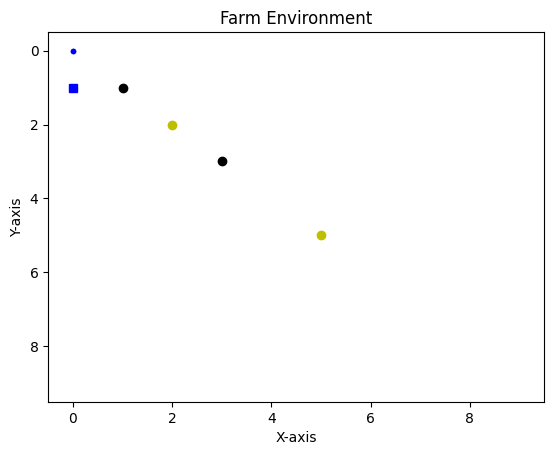

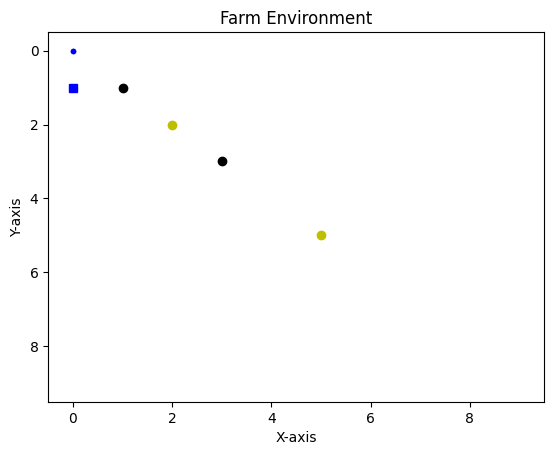

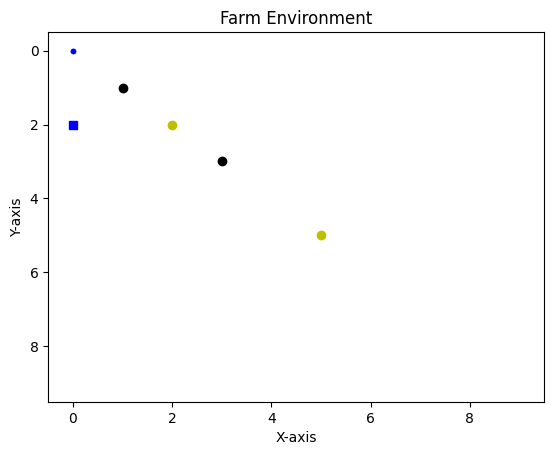

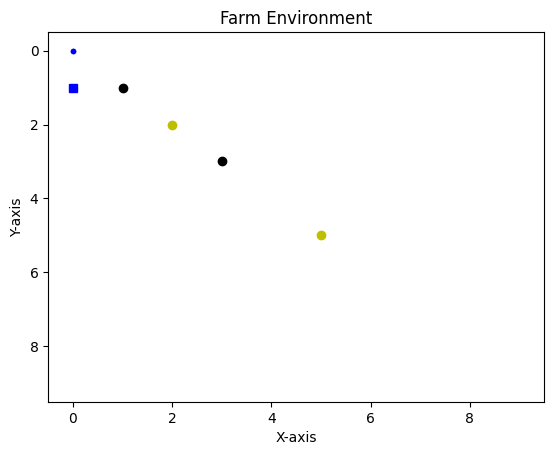

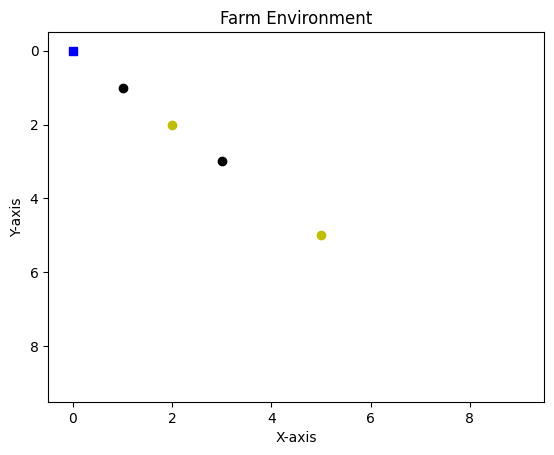

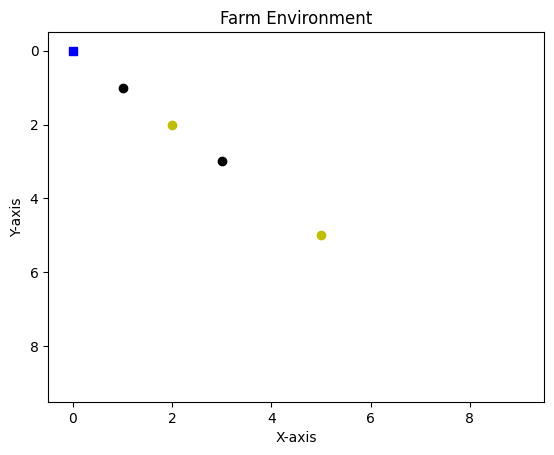

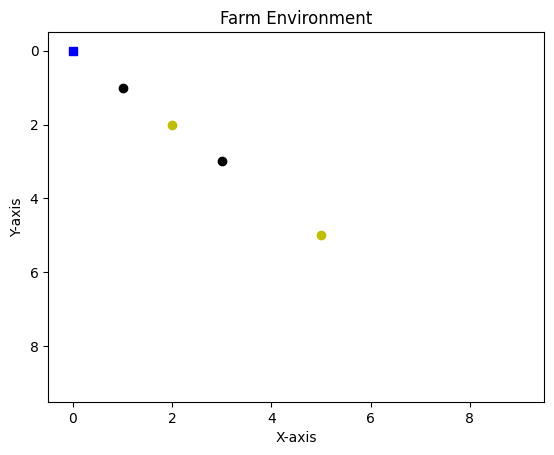

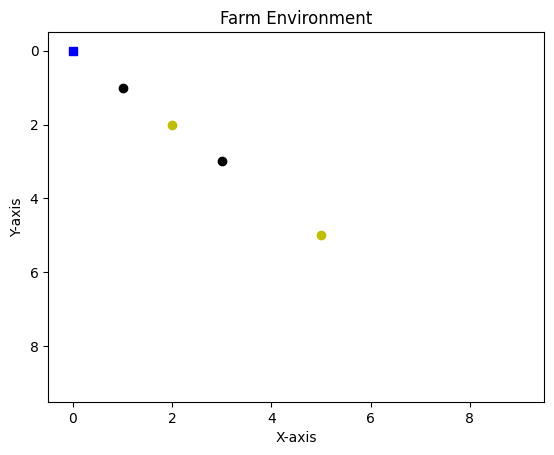

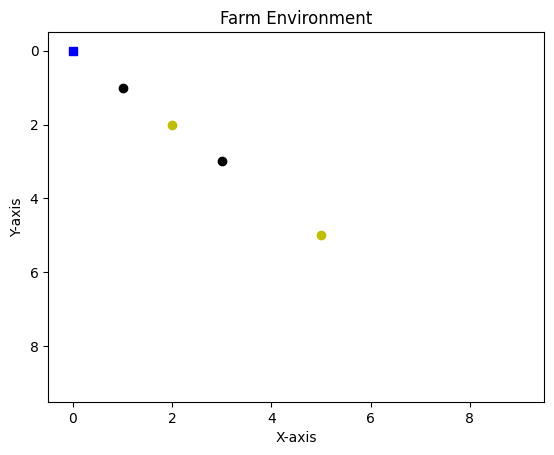

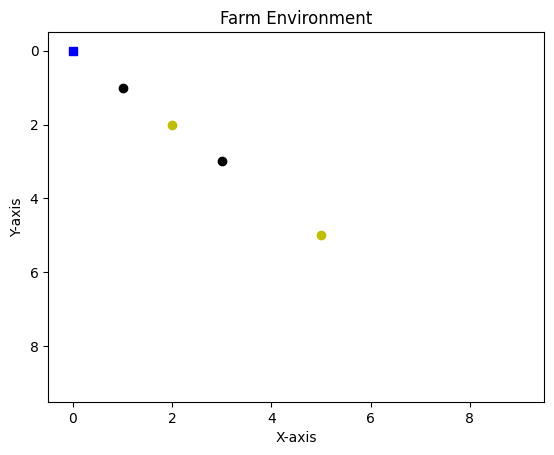

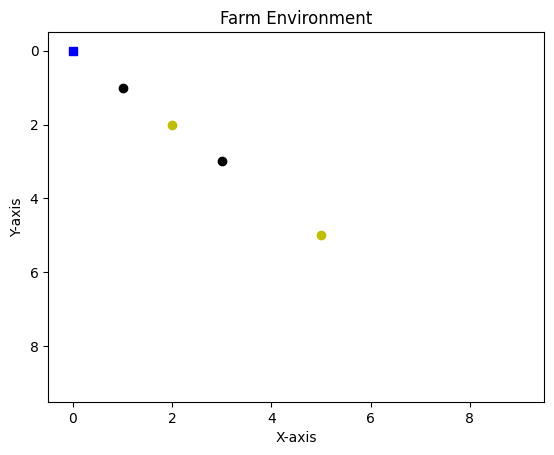

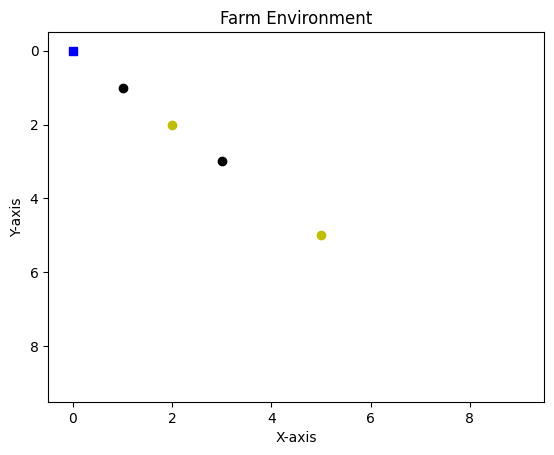

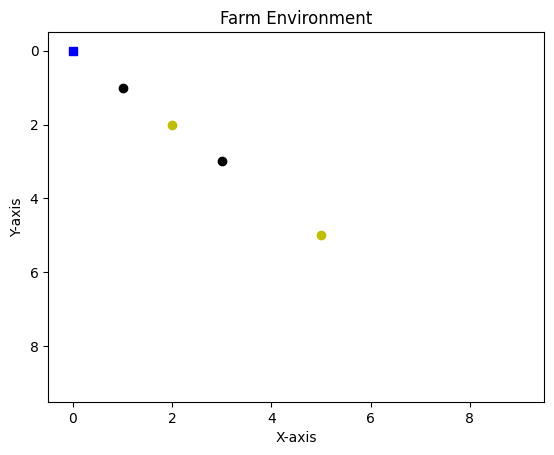

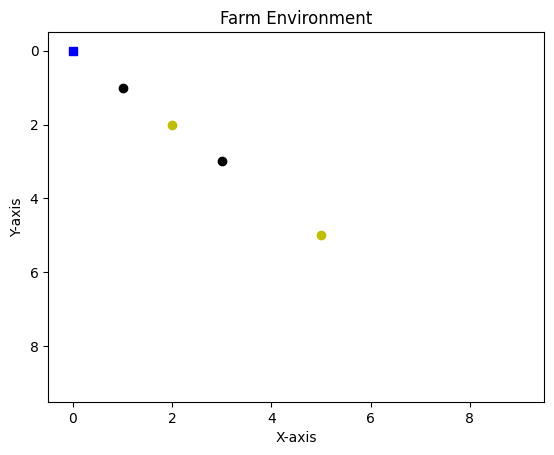

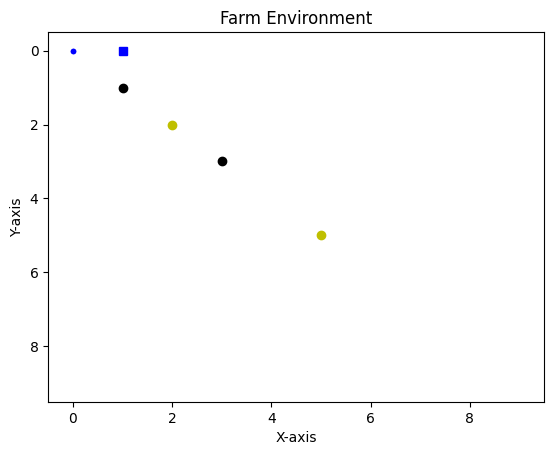

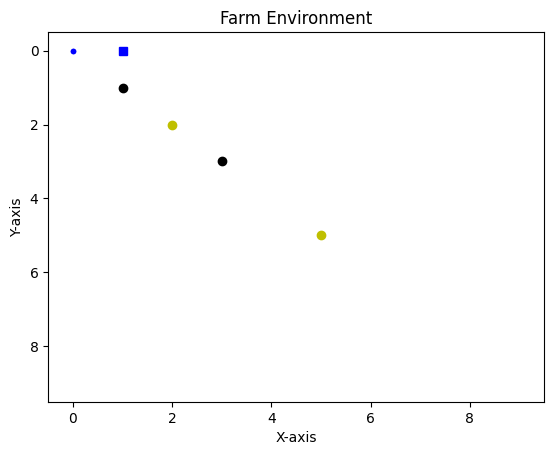

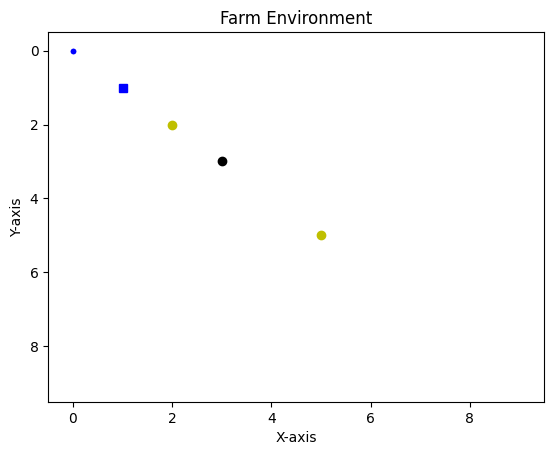

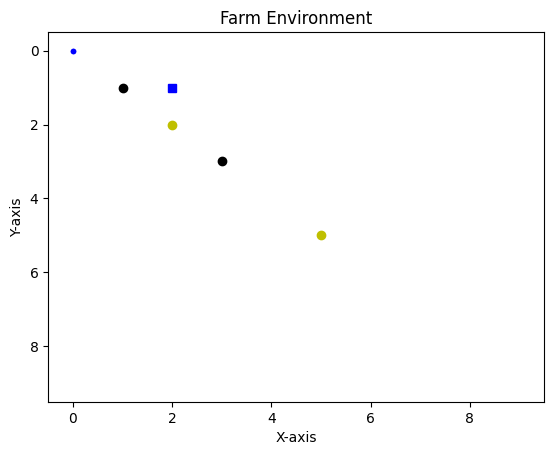

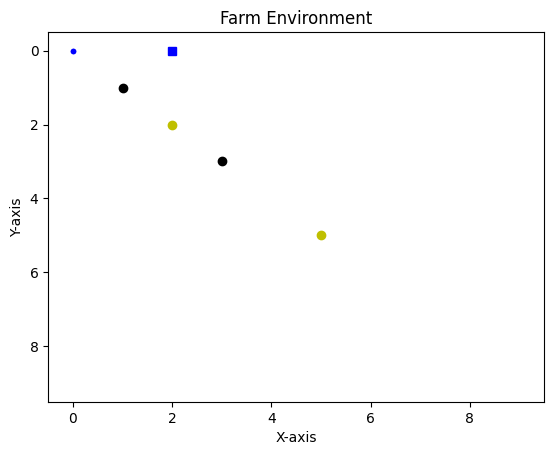

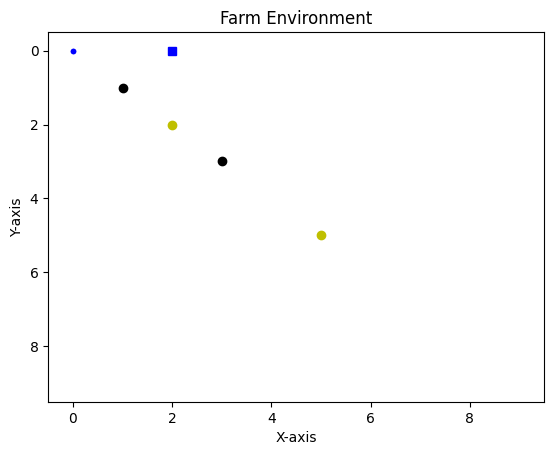

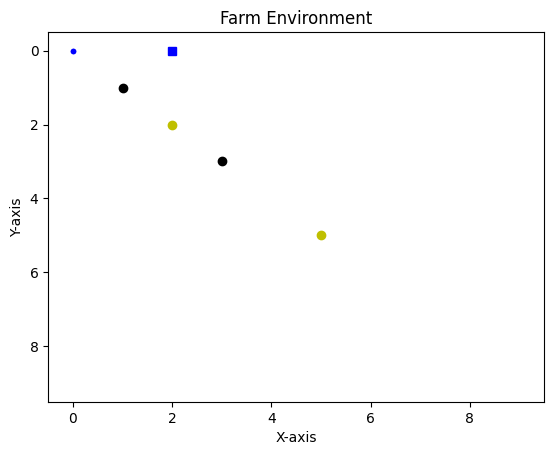

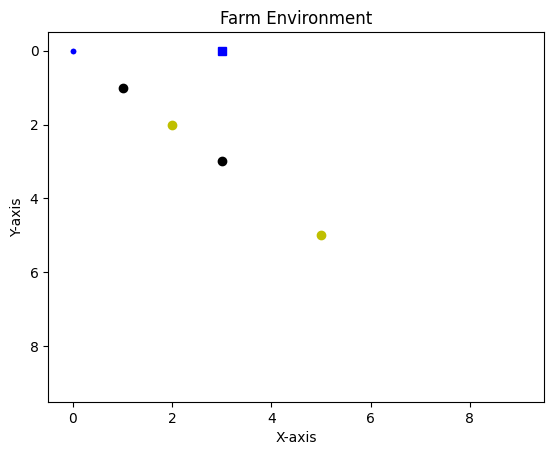

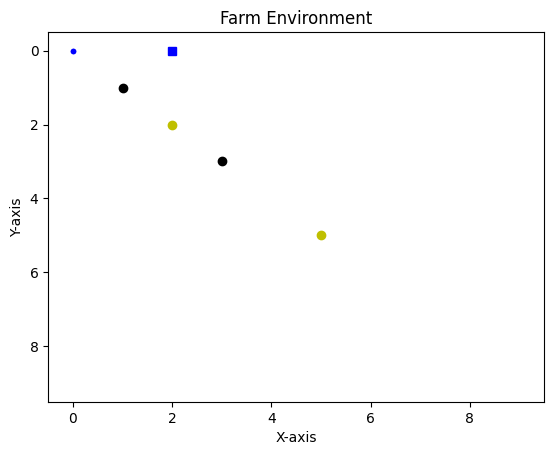

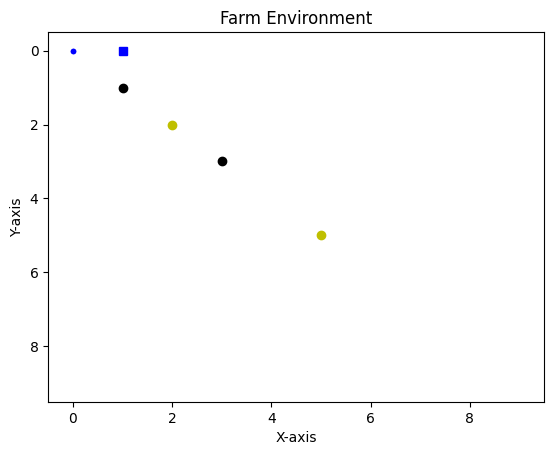

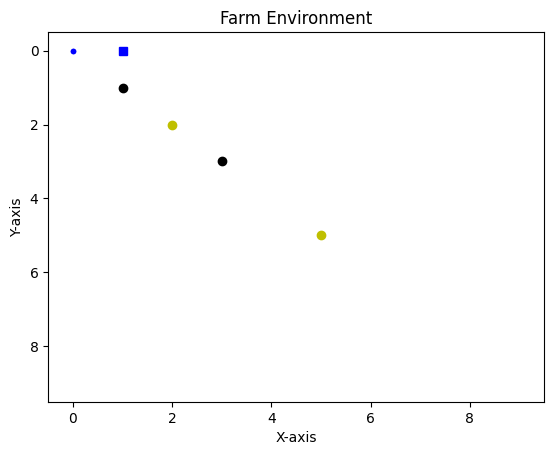

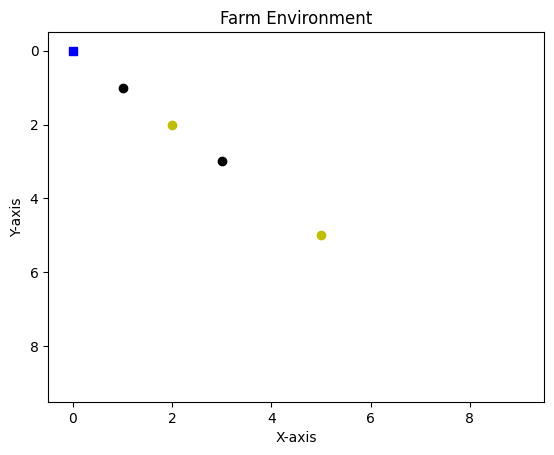

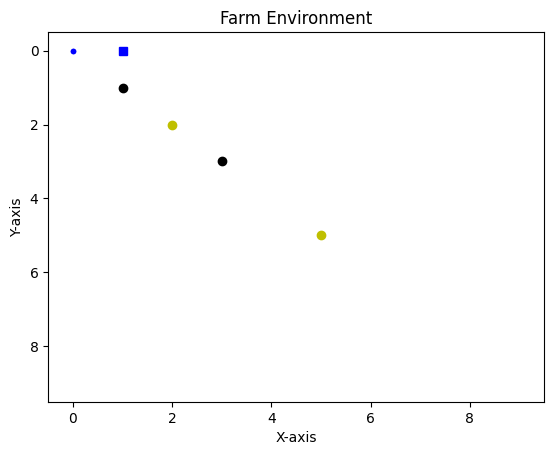

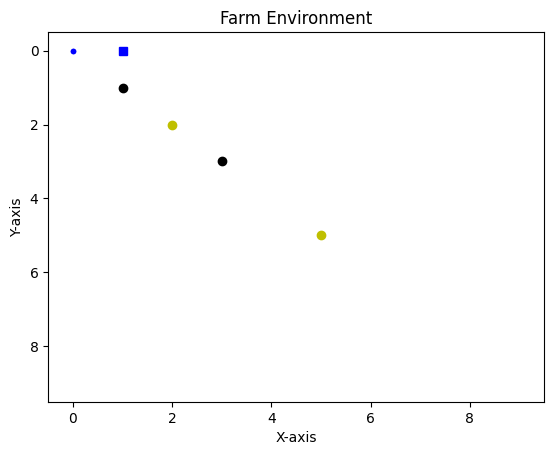

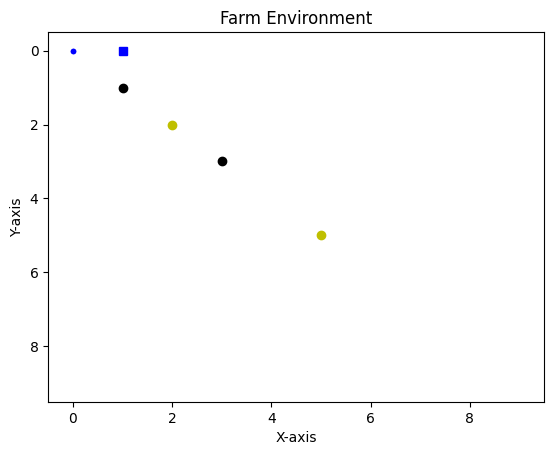

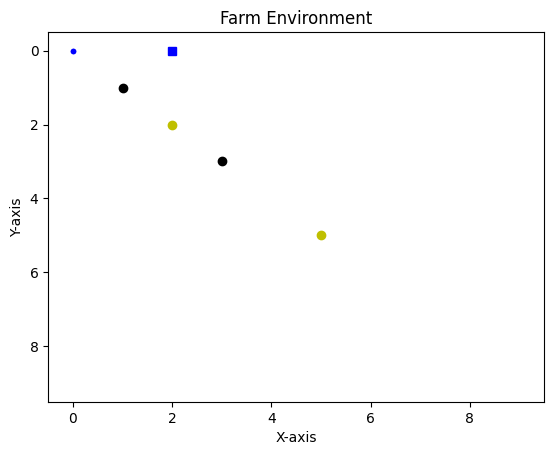

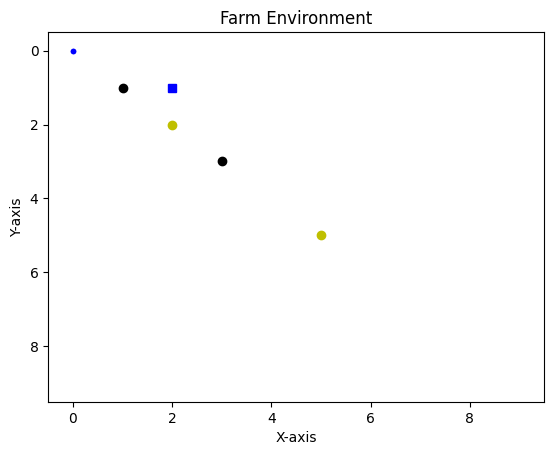

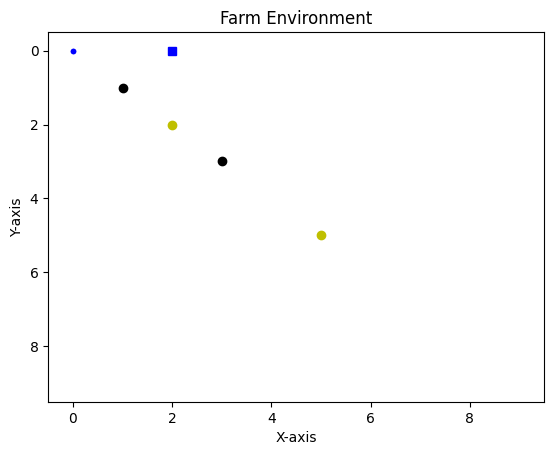

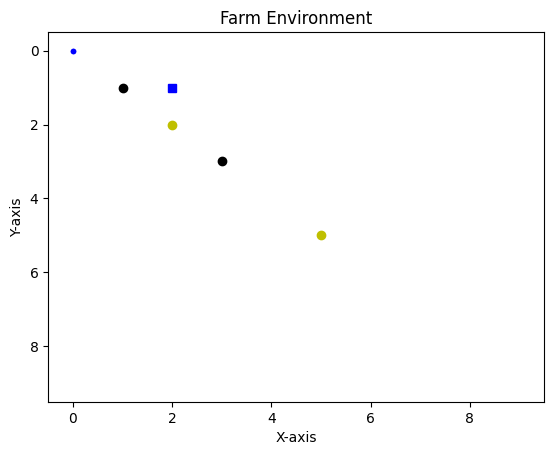

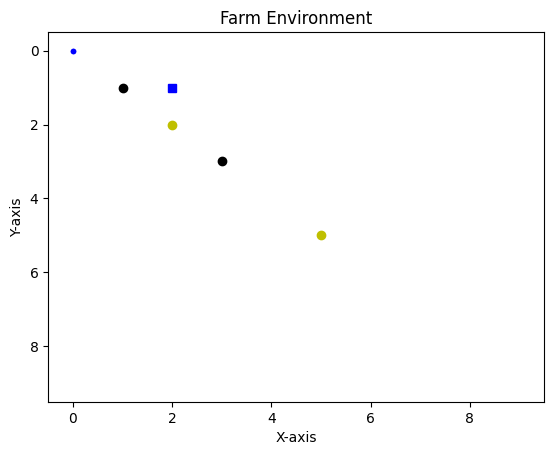

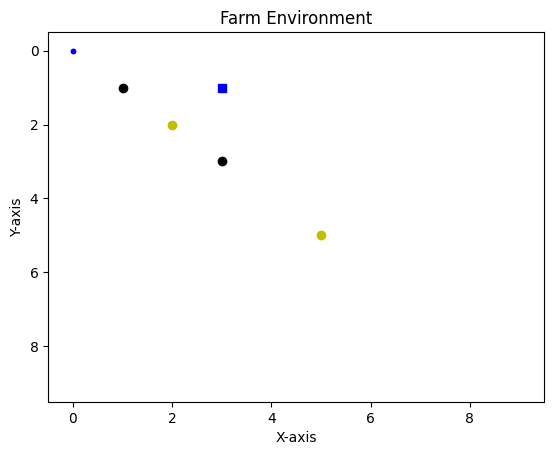

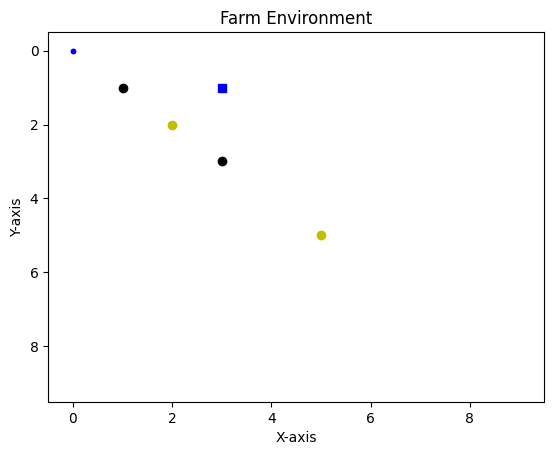

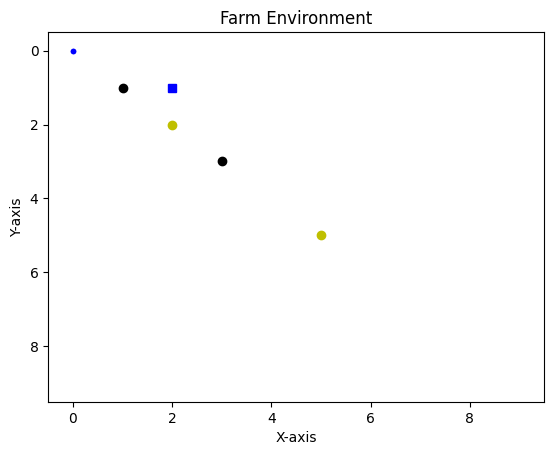

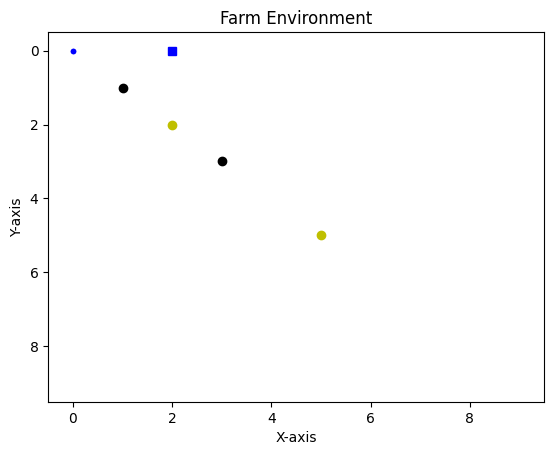

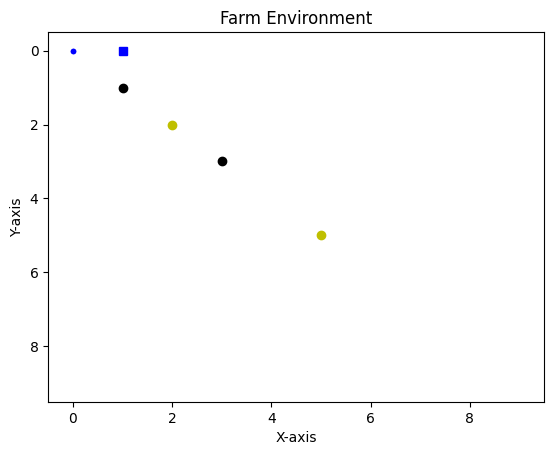

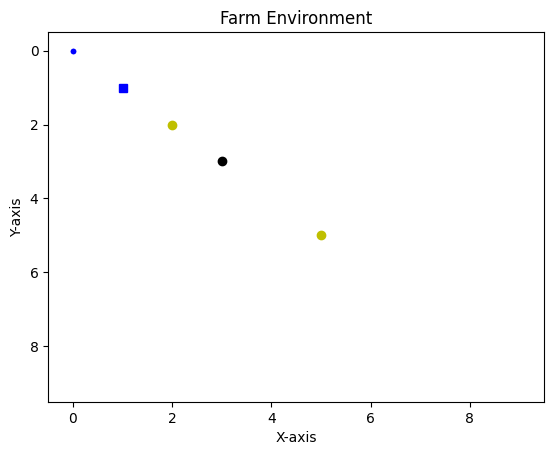

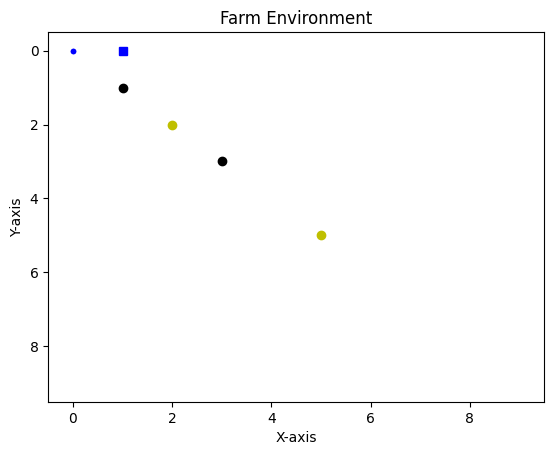

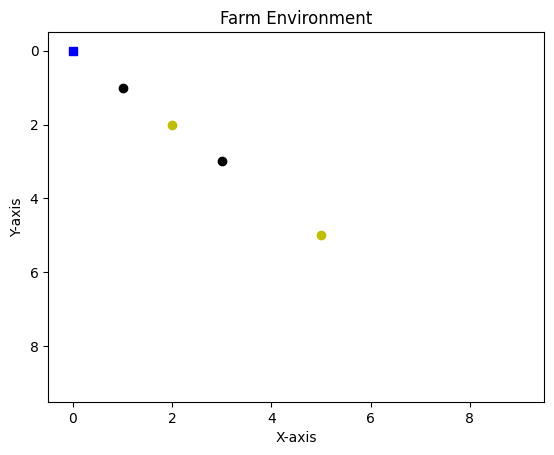

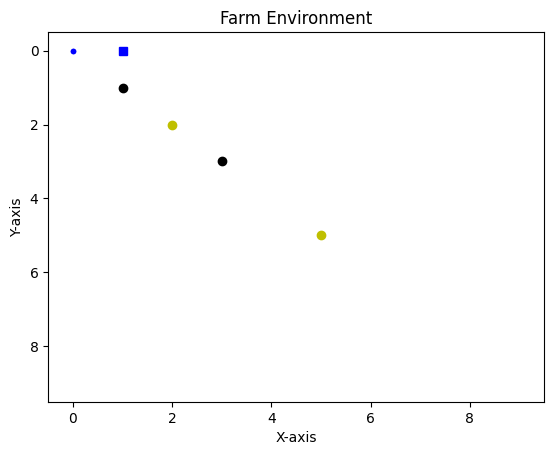

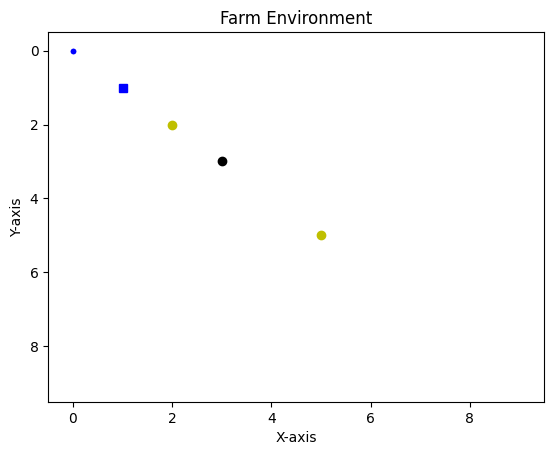

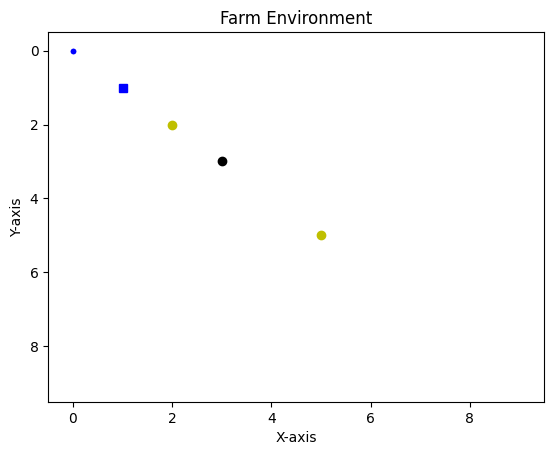

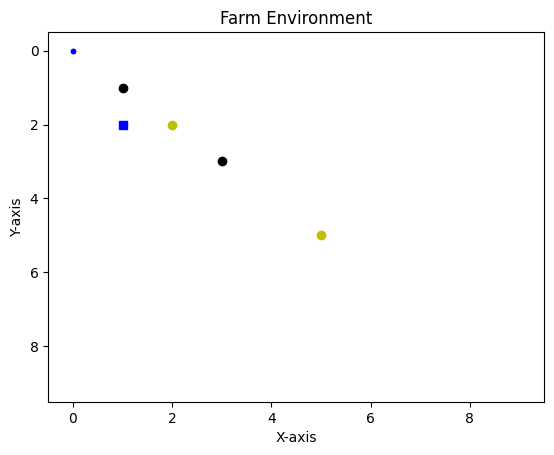

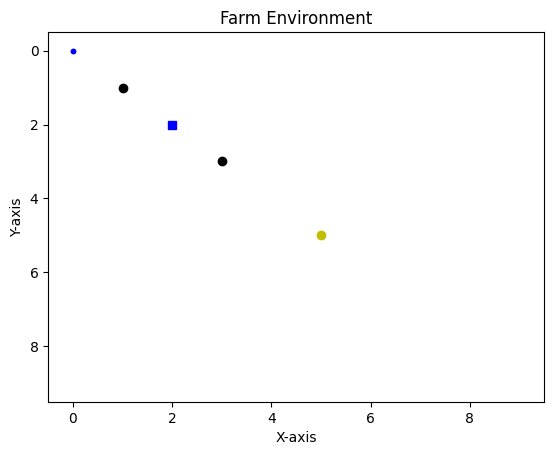

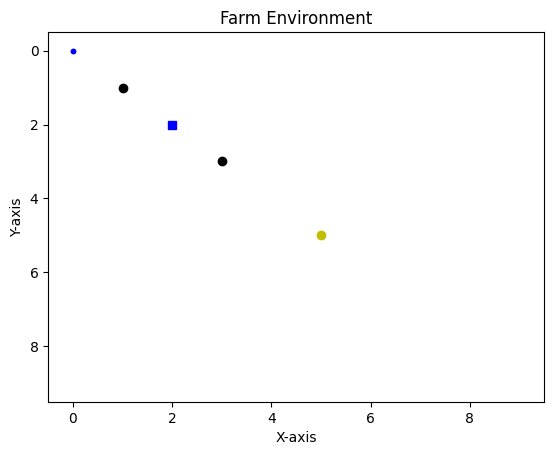

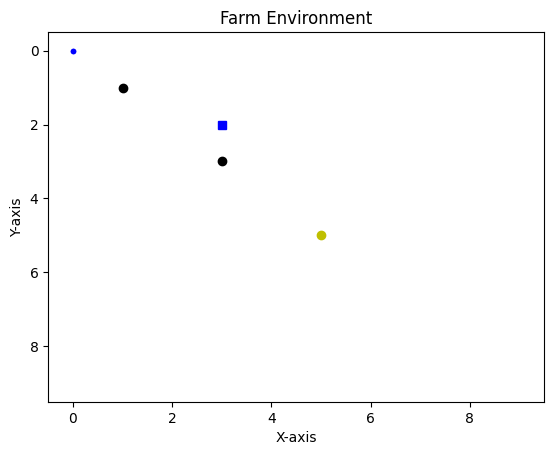

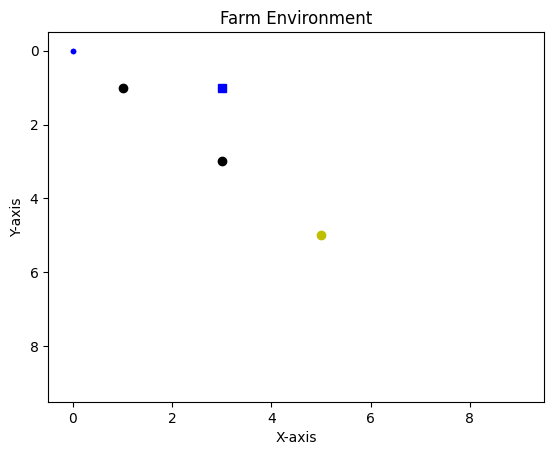

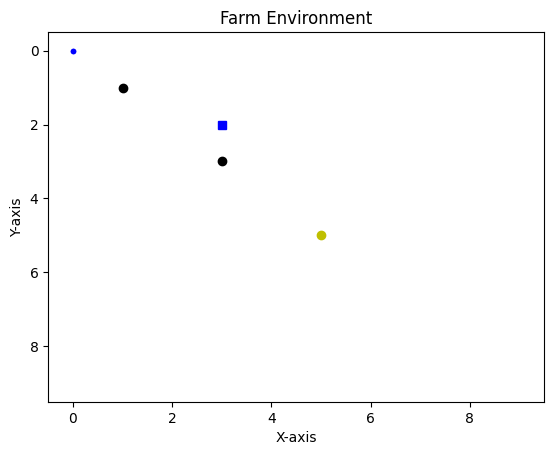

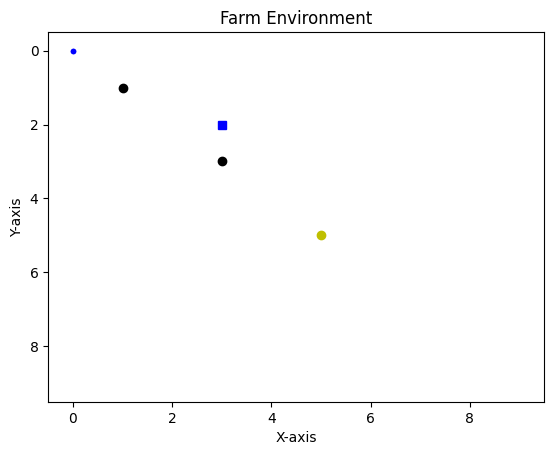

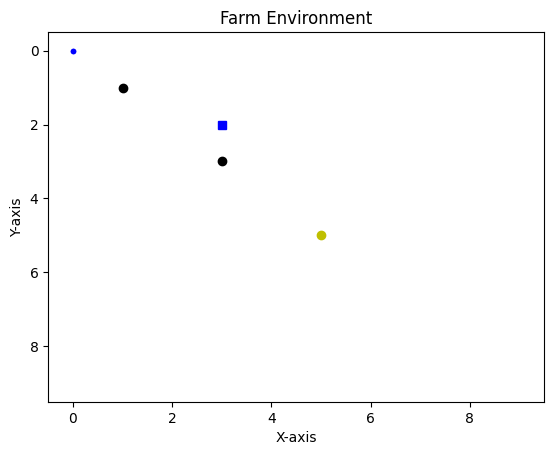

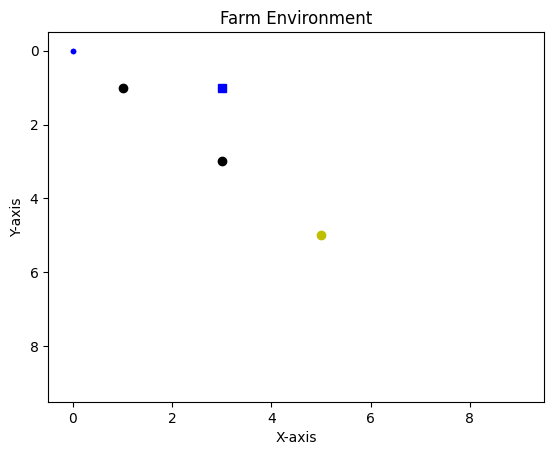

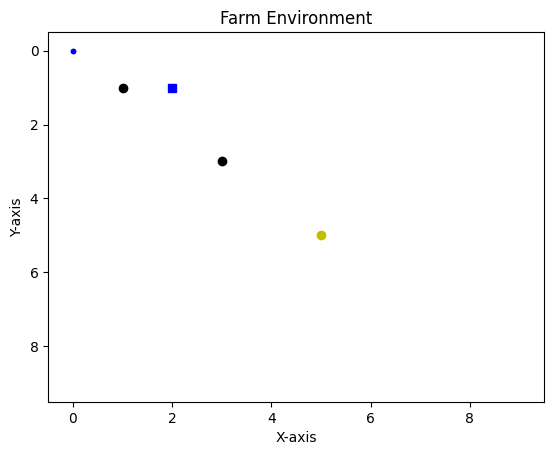

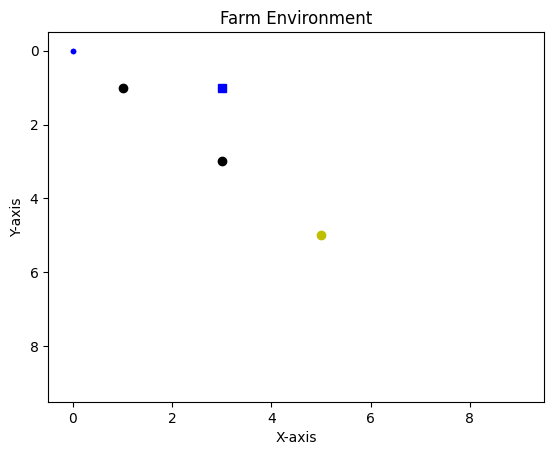

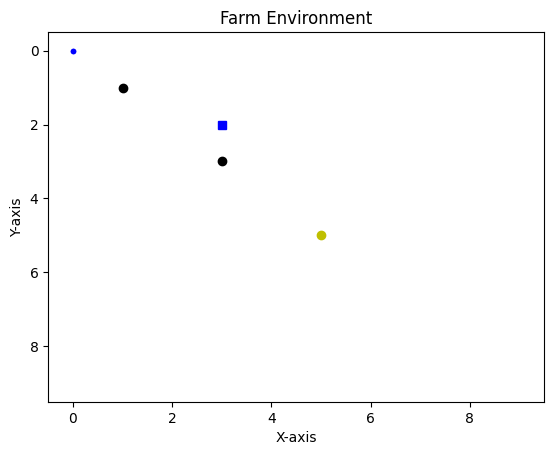

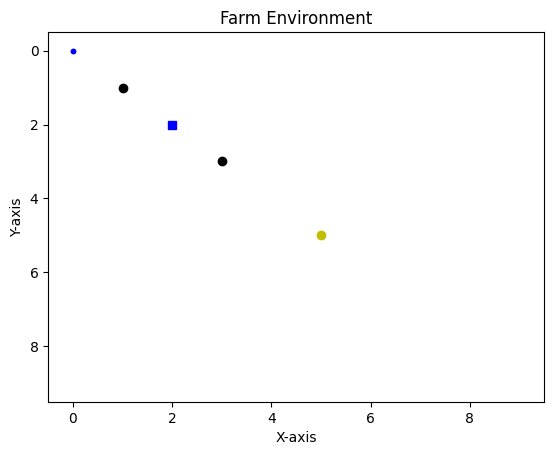

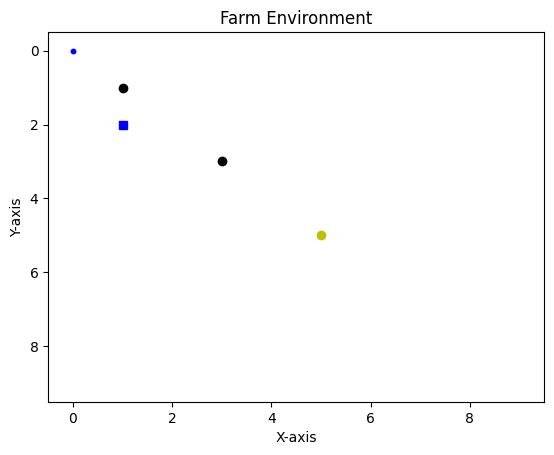

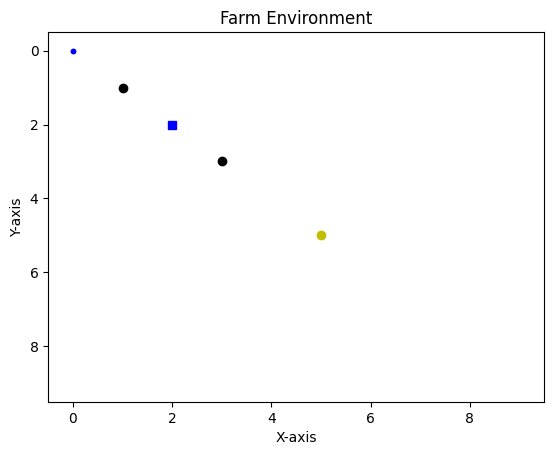

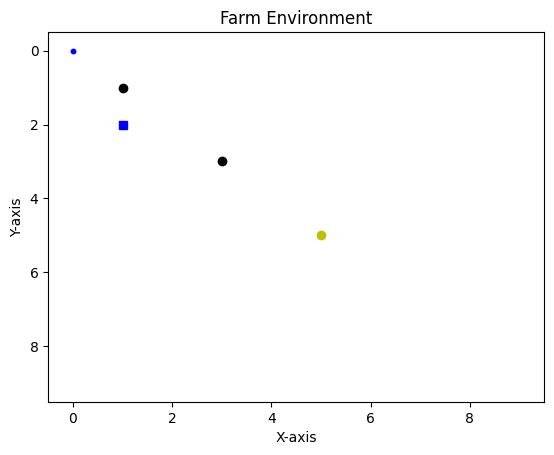

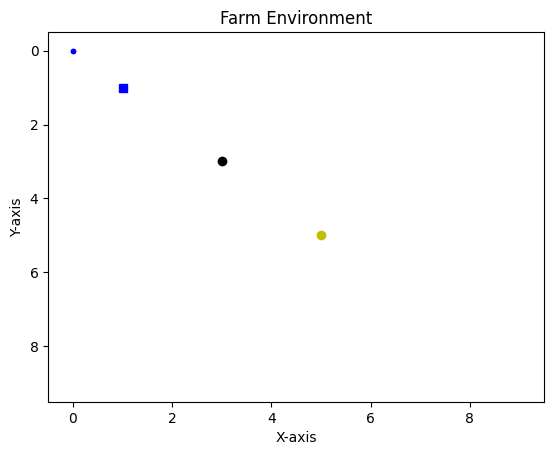

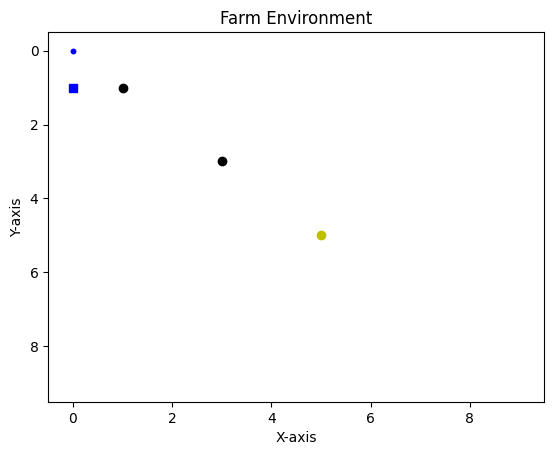

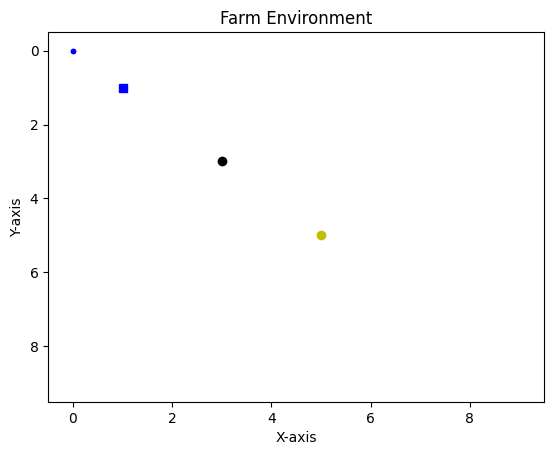

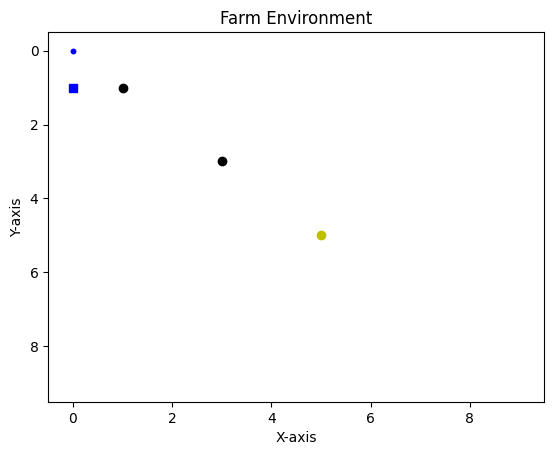

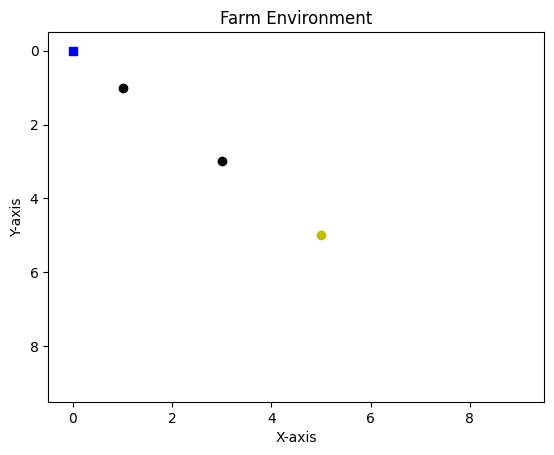

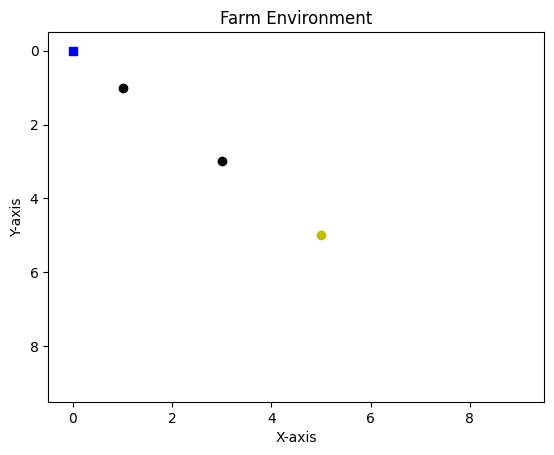

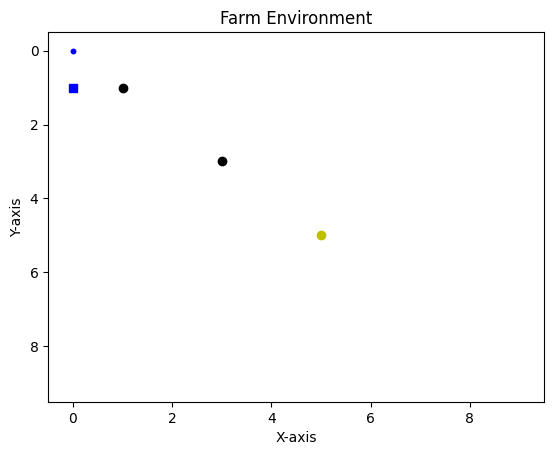

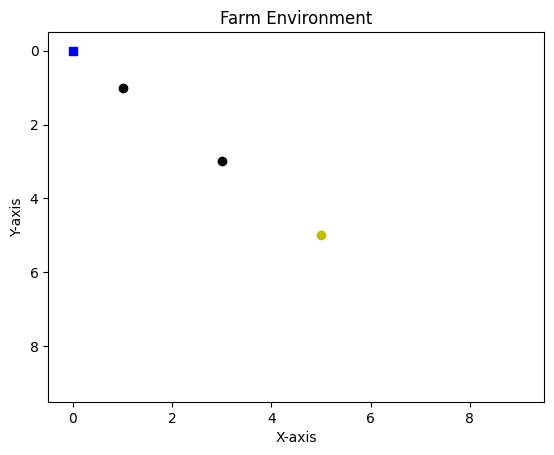

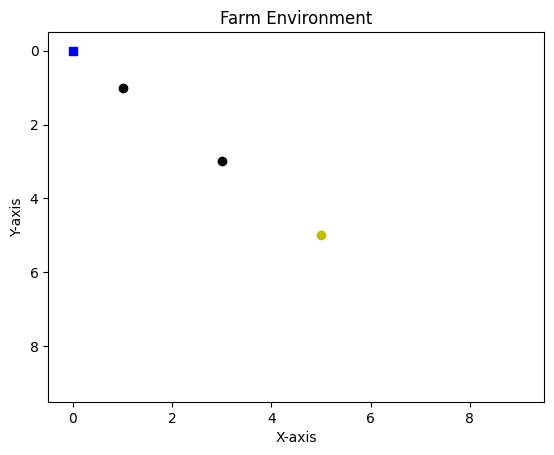

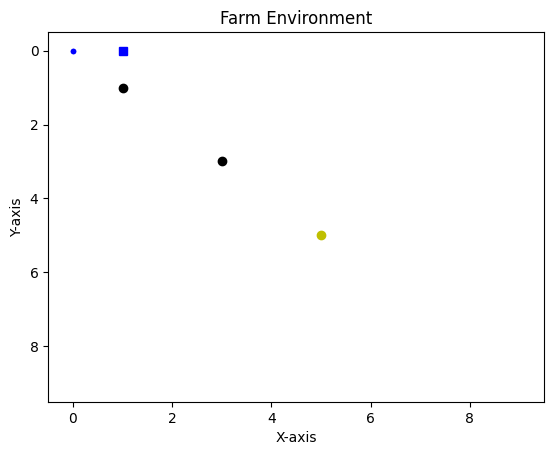

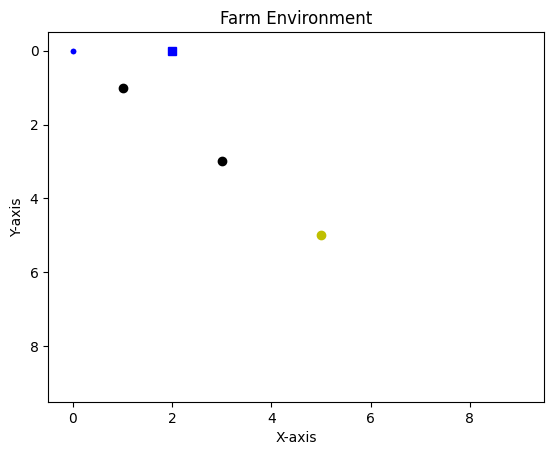

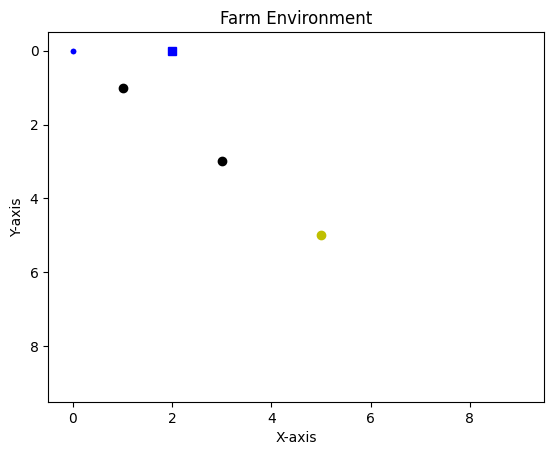

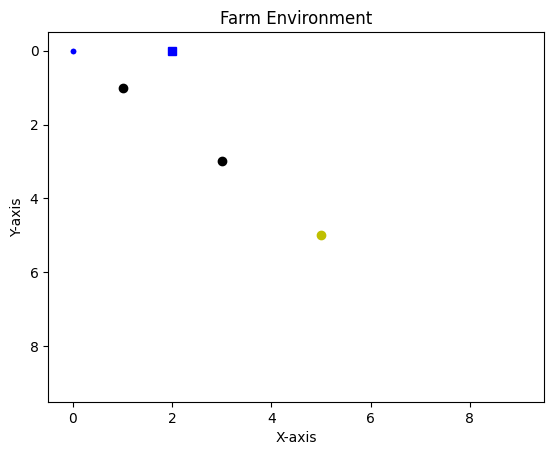

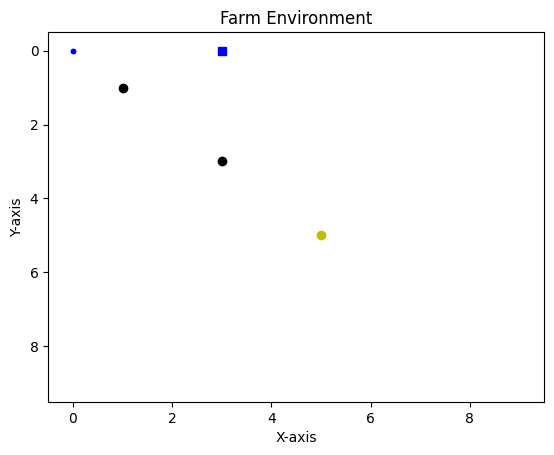

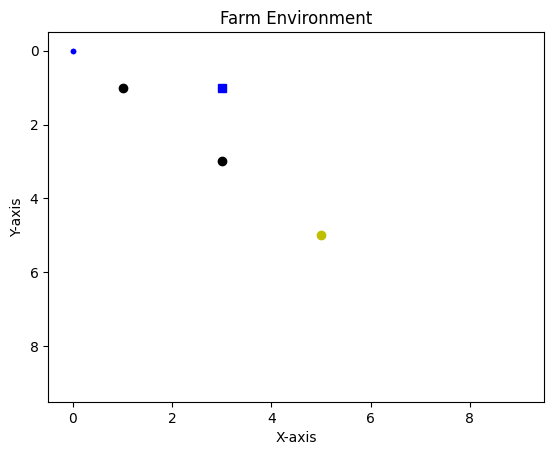

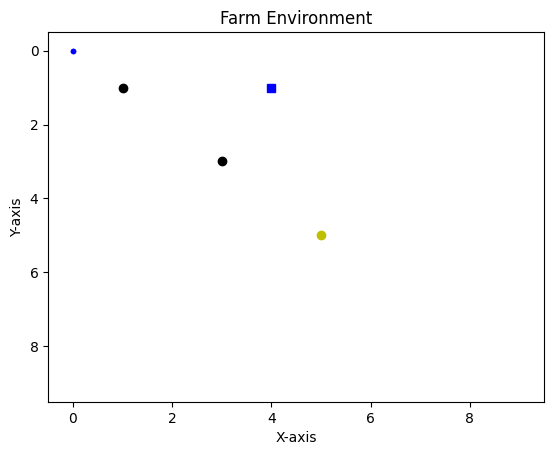

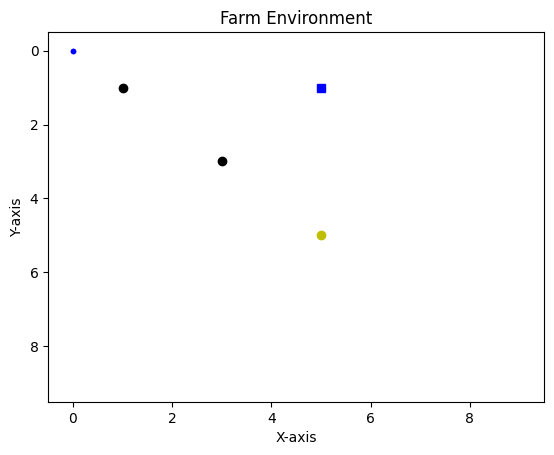

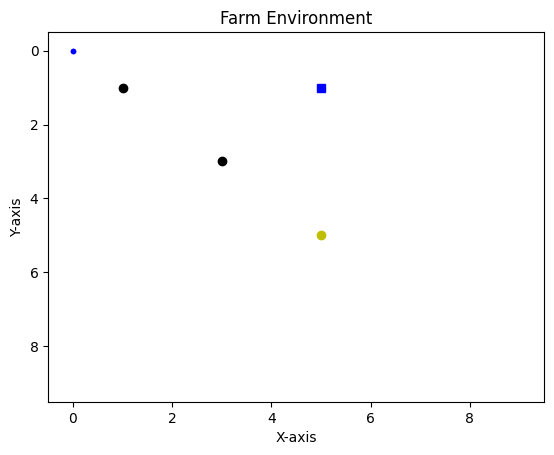

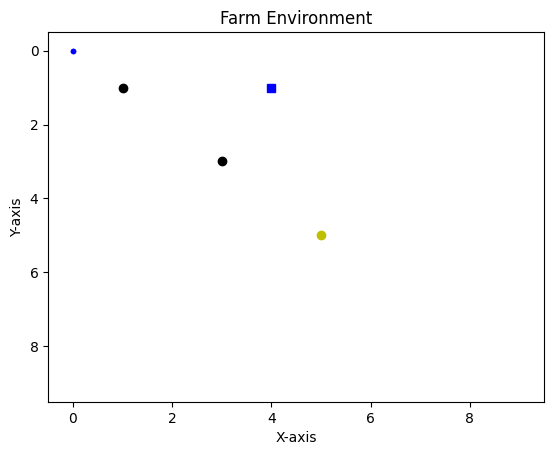

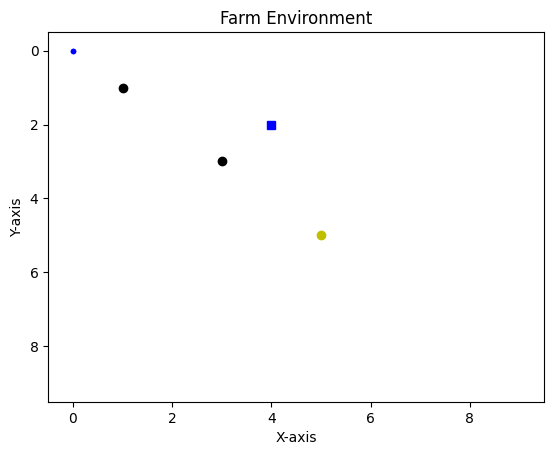

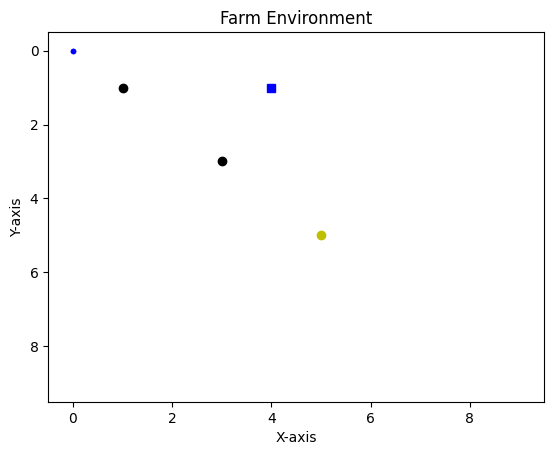

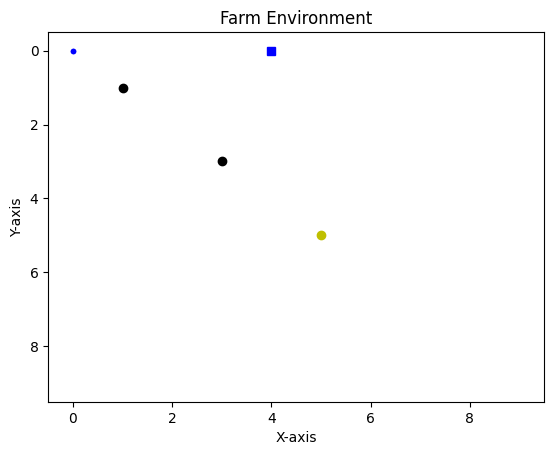

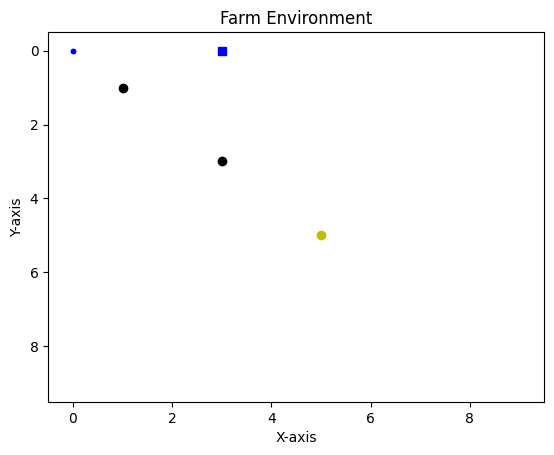

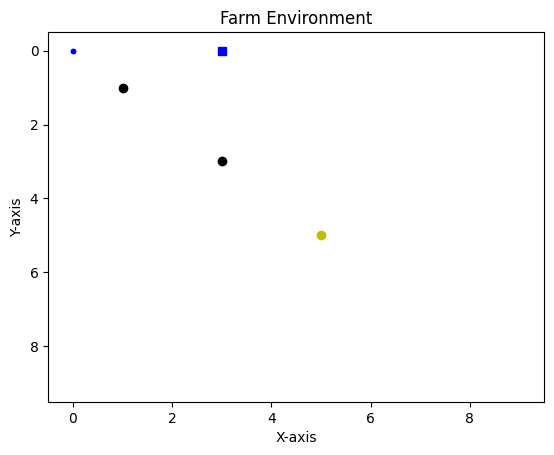

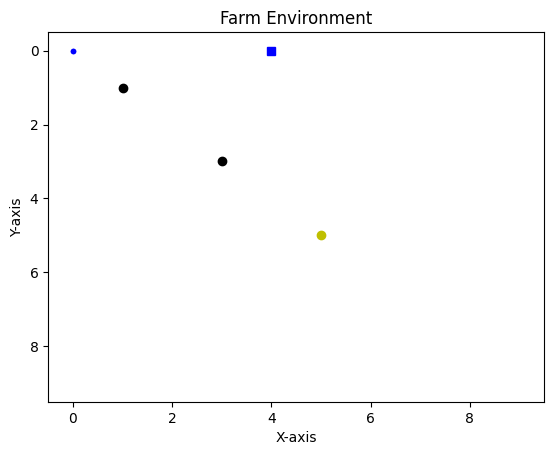

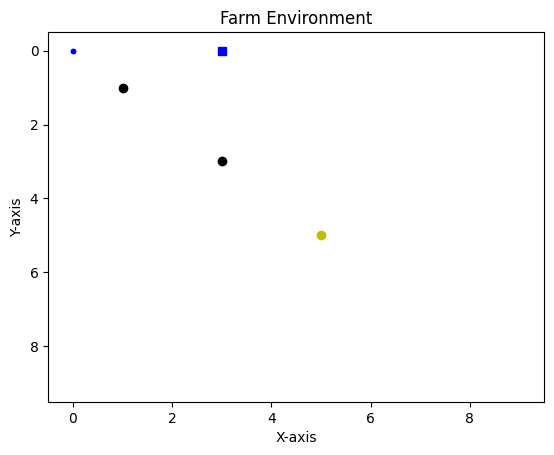

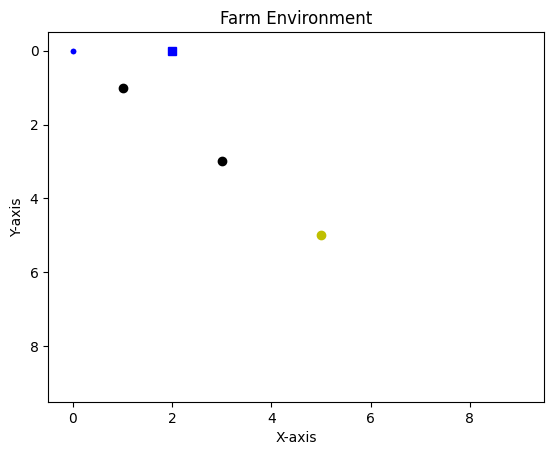

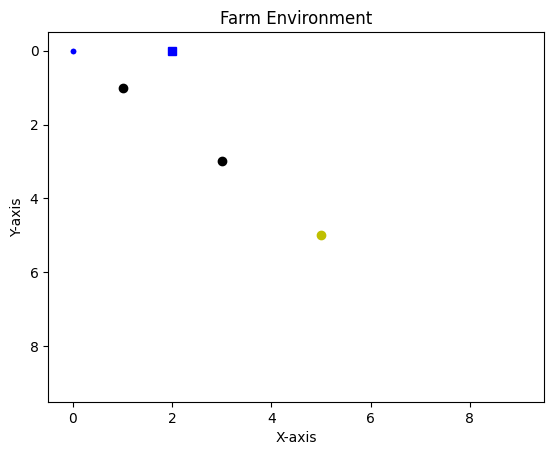

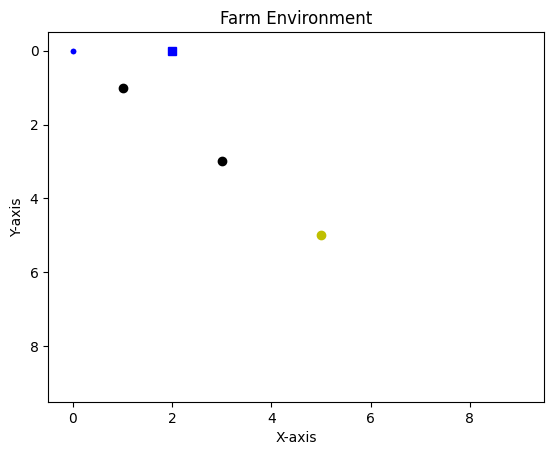

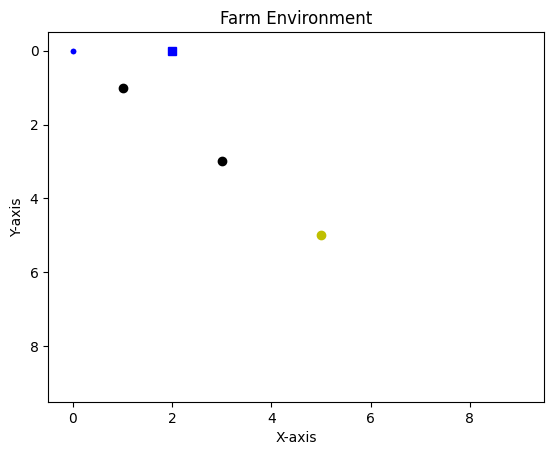

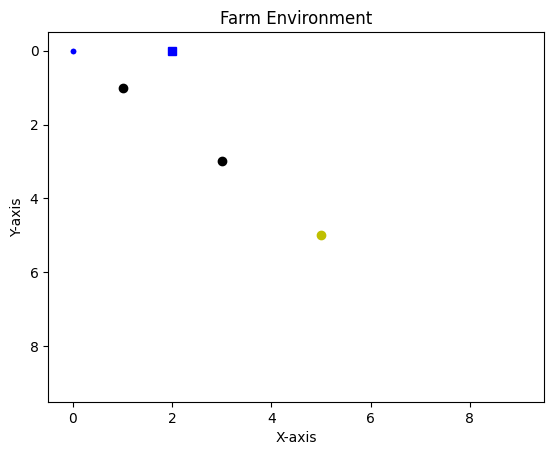

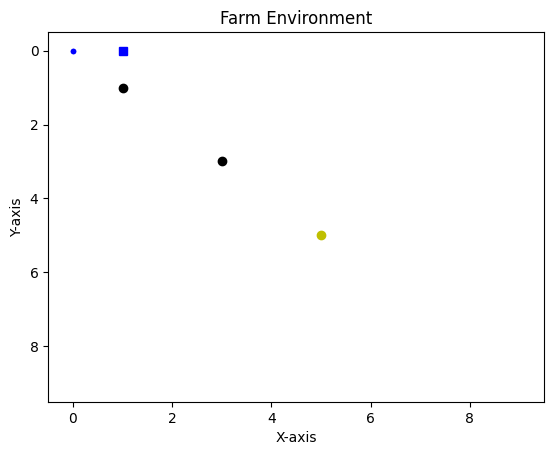

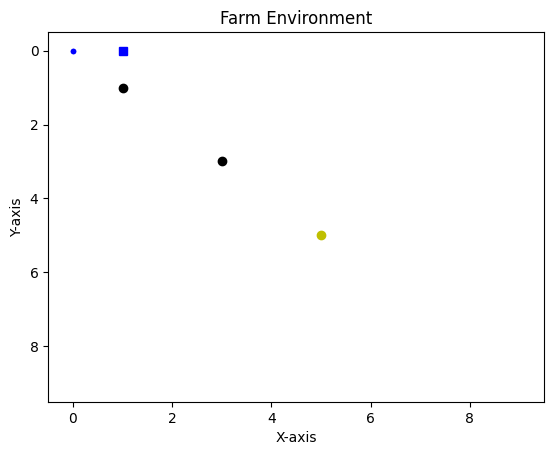

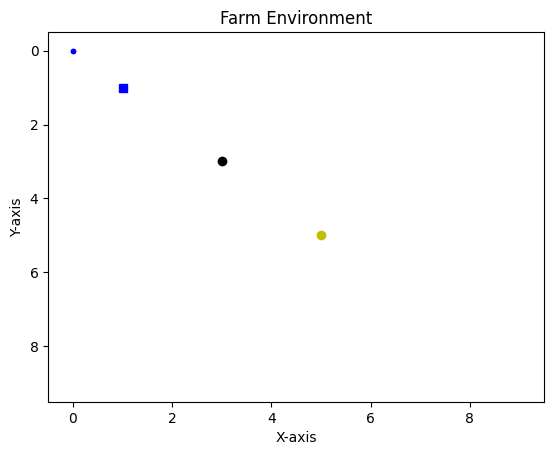

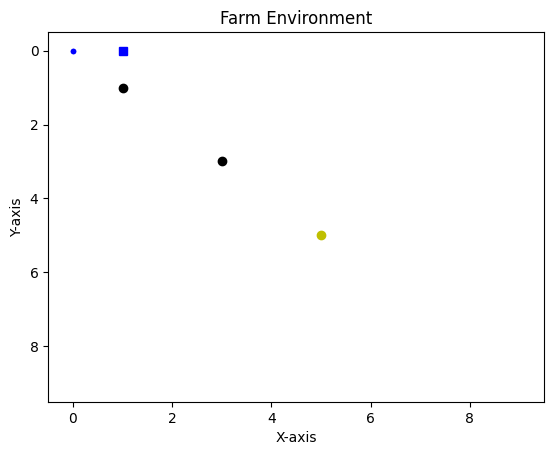

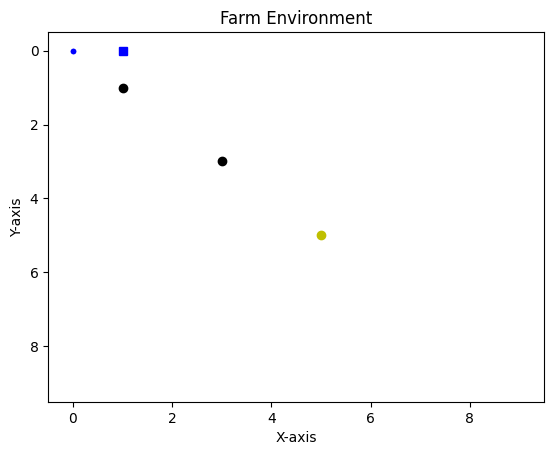

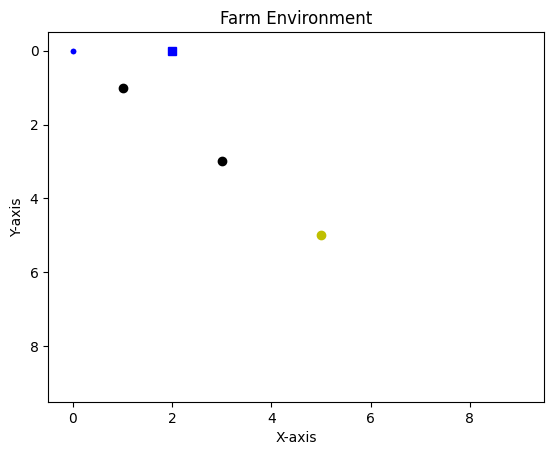

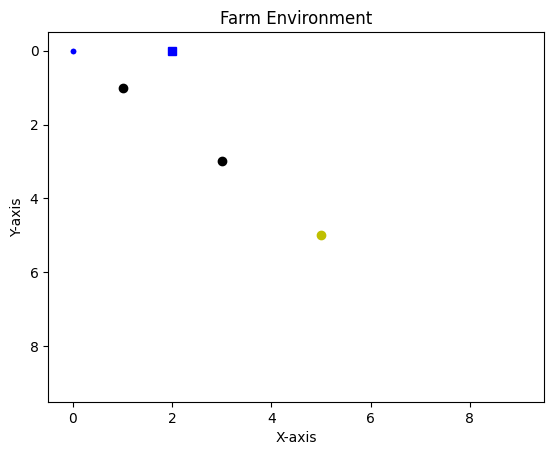

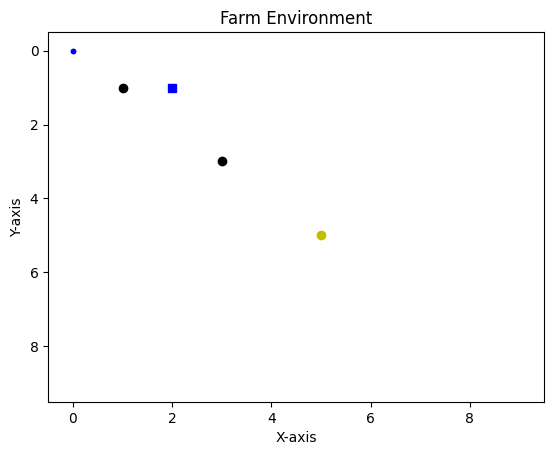

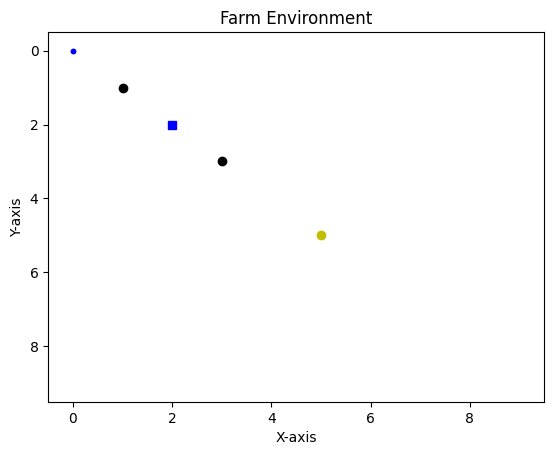

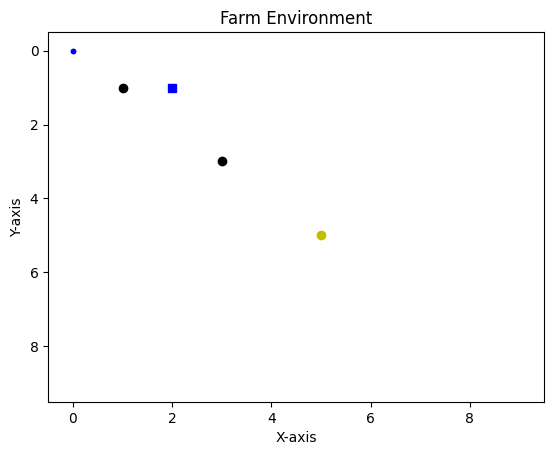

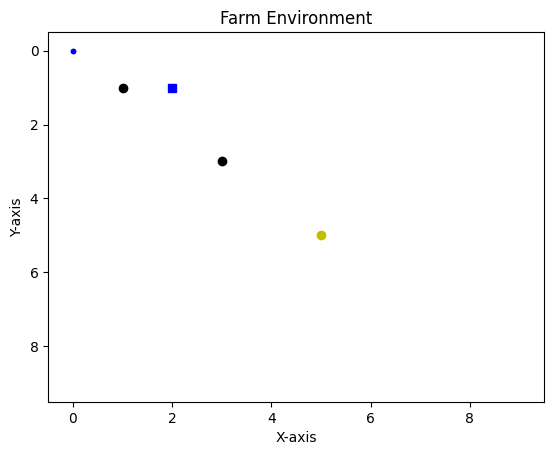

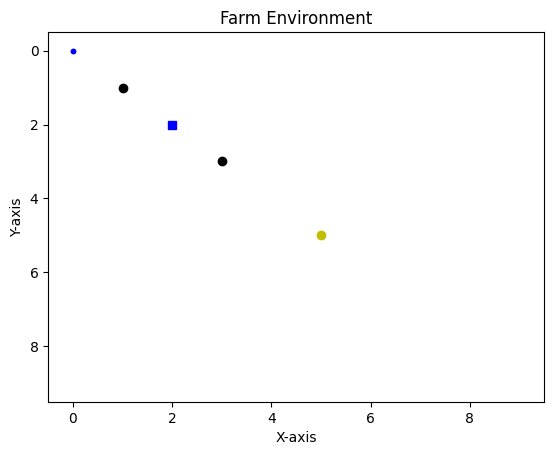

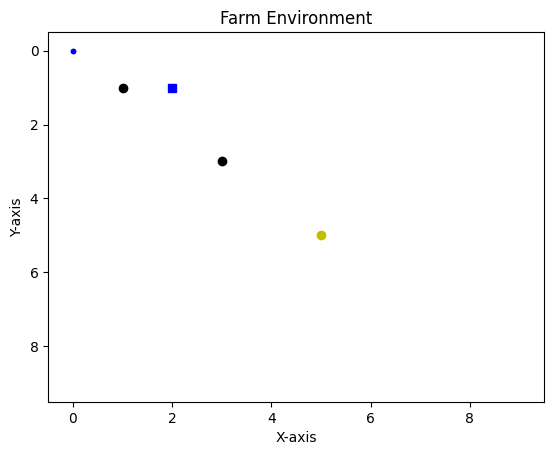

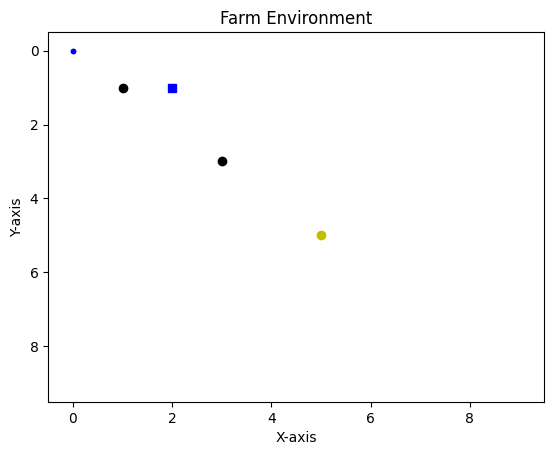

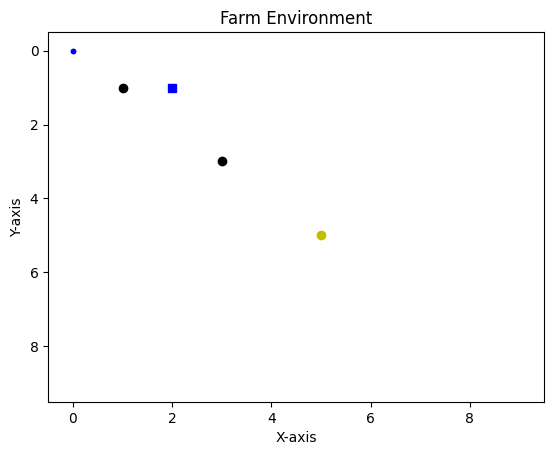

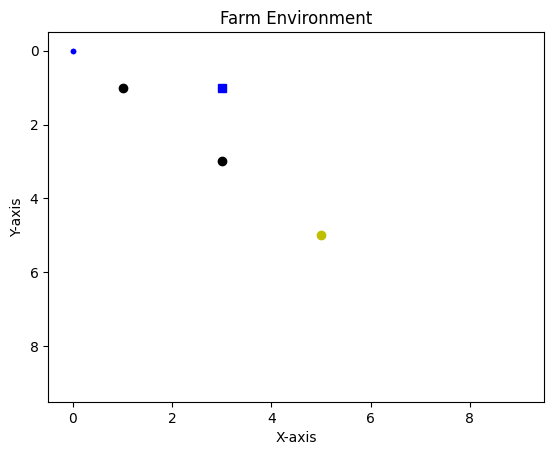

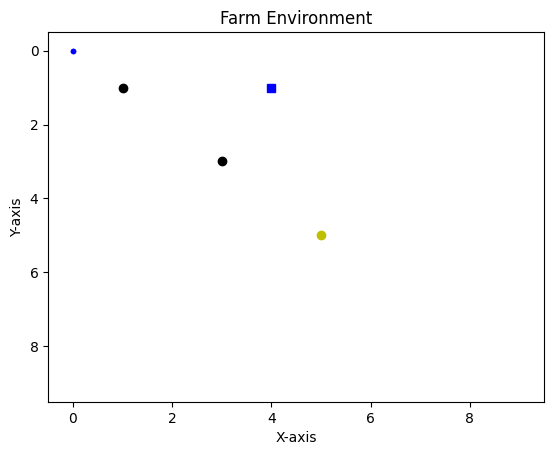

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [37]:
def train_agent(episodes=1000):
    # Initialize the environment
    env = FarmEnv(grid_size=(10, 10), wheat_spawns=[(2, 2), (5, 5)], obstacles=[(1, 1), (3, 3)])

    # Initialize agents
    harvester = Combine()

    for episode in range(episodes):
        # Get only the observation from reset
        state = env.reset()[0]  # Extracting the first element which is the observation
        done = False
        total_reward = 0

        while not done:
            action_harvester = harvester.choose_action(state)
            # Get only the observation from step
            next_state, reward, done, _ = env.step(action_harvester)  # Extracting the observation
            next_state = next_state[0]  # Extracting the first element which is the observation

            harvester.learn(state, action_harvester, reward, next_state)
            state = next_state
            env.render()
            total_reward += reward

        harvester.update_epsilon()
        
        # Log performance and learning progress
        print(f"Episode: {episode}, Total Reward: {total_reward}")

    # Return trained agents and environment for further use or analysis
    return harvester, env

if __name__ == "__main__":
    trained_harvester, trained_env = train_agent()
